<a href="https://colab.research.google.com/github/JVR27XD/SAM/blob/main/TinySAMTFG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Configuración inicial y preparación del entorno para TinySAM en Google Colab
Este bloque de código se encarga de preparar el entorno de trabajo para utilizar el modelo TinySAM.
Primero descarga el repositorio oficial desde GitHub, cambia el directorio de trabajo al recién clonado y crea las carpetas necesarias para almacenar los pesos del modelo y las salidas generadas durante las pruebas o inferencias.

In [ ]:
# Clona el repositorio TinySAM desde GitHub.
# Esto descarga todo el código fuente necesario para usar el modelo.
!git clone -q https://github.com/xinghaochen/TinySAM.git
# Cambia el directorio de trabajo actual a la carpeta del repositorio recién clonado.
%cd TinySAM
# Crea (si no existen) dos carpetas:
# - "weights" → para guardar los pesos del modelo TinySAM
# - "outputs" → para almacenar los resultados de las pruebas o inferencias
!mkdir -p weights outputs

fatal: destination path 'TinySAM' already exists and is not an empty directory.
/content/TinySAM


# Carga y verificación del modelo TinySAM desde checkpoint

Carga del modelo a partir de un archivo de checkpoint previamente guardado.

El flujo es el siguiente:

Define la ruta donde se encuentra el checkpoint en Google Drive.

Verifica la existencia del archivo y muestra su tamaño en MB.

Importa los módulos necesarios para construir y cargar el modelo TinySAM.

Define la función load_tinysam_model() que:

Lee el checkpoint con seguridad (safe_globals).

Reconstruye la arquitectura del modelo (build_sam_vit_t).

Carga los pesos y avisa si hay discrepancias (faltantes o inesperados).

Pasa el modelo a GPU (cuda) y lo deja en modo evaluación.

Carga finalmente el modelo en la variable model_tinysam.

In [ ]:
# Configuración de checkpoint
CKPT_TINYSAM = "/content/drive/MyDrive/Colab Notebooks/TFG/TinySAM/tinysam_42.3.pth"

# Verificación del archivo
import os
# Comprobamos si el archivo existe en la ruta indicada.
if not os.path.exists(CKPT_TINYSAM):
# Si no existe, lanzamos un error y detenemos la ejecución.
    raise FileNotFoundError(f"❌ No existe el checkpoint: {CKPT_TINYSAM}")
else:
# Si existe, calculamos su tamaño en MB y lo mostramos en pantalla.
    size_mb = os.path.getsize(CKPT_TINYSAM) / (1024*1024)
    print(f"✅ Checkpoint encontrado ({size_mb:.2f} MB)")

# Importar TinySAM
import torch
from tinysam.build_sam import build_sam_vit_t
from tinysam.modeling.sam import Sam

def load_tinysam_model(ckpt_path, device="cuda"):

    with torch.serialization.safe_globals([Sam]):
        ckpt_data = torch.load(ckpt_path, map_location=device, weights_only=True)

    model = build_sam_vit_t(checkpoint=None)
  # Carga de pesos en la arquitectura
    missing, unexpected = model.load_state_dict(ckpt_data, strict=False)

    print(f"✅ Modelo cargado desde {ckpt_path}")
    if missing: print("⚠ Pesos faltantes:", missing)
    if unexpected: print("⚠ Pesos inesperados:", unexpected)
 # Pasamos el modelo a GPU (o CPU según el parámetro) y lo ponemos en modo evaluación
    model.to(device)
    model.eval()
    return model

# === Cargar modelo ===
model_tinysam = load_tinysam_model(CKPT_TINYSAM, device="cuda")

✅ Checkpoint encontrado (38.82 MB)


/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/content/TinySAM/tinysam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with tinysam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/content/TinySAM/tinysam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with tinysam.modeling.tiny_vit_sam.tin

✅ Modelo cargado desde /content/drive/MyDrive/Colab Notebooks/TFG/TinySAM/tinysam_42.3.pth


# Evaluación de TinySAM con letterboxing

Este bloque implementa la evaluación para TinySAM, aplicando la técnica de letterboxing (redimensionado con conservación de aspecto + padding), lo que asegura consistencia con otros modelos.

Incluye:

Letterboxing de imágenes, máscaras y prompts → asegura entrada uniforme de 1024×1024

Preprocesado y codificación de imágenes → normalización tipo ImageNet y extracción de embeddings con el encoder de TinySAM.

Uso de prompts (punto, caja, combinación, multipunto) → para guiar la segmentación.

Predicción de máscaras → mediante el prompt encoder y el mask decoder.

Cálculo de métricas (IoU, Dice, Precisión, Recall).

Visualización→ comparación de GT y predicciones.

Evaluación en dataset completo → devuelve métricas por modalidad de prompt.

En resumen, este bloque sirve para probar TinySAM sobre un conjunto de datos, con distintos tipos de prompting, obteniendo métricas y visualizaciones comparables a otros modelos.

In [ ]:
# TinySAM con LETTERBOXING
import os, time, inspect, importlib
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
import torchvision.transforms as T
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

# ======================================================
# 1) PREPROCESAMIENTO: letterbox imagen/máscara/prompts
#     + normalización ImageNet y tensor a dispositivo
# ======================================================

def letterbox_resize(pil_img, size=1024, fill=(0, 0, 0)):

    w, h = pil_img.size
    scale = size / max(w, h)
    new_w, new_h = int(round(w * scale)), int(round(h * scale))
    img_resized = pil_img.resize((new_w, new_h), Image.BILINEAR)

    canvas = Image.new("RGB", (size, size), fill)
    pad_x = (size - new_w) // 2
    pad_y = (size - new_h) // 2
    canvas.paste(img_resized, (pad_x, pad_y))
    return canvas, scale, pad_x, pad_y

def letterbox_mask(mask_pil, scale, pad_x, pad_y, size=1024):
    """Aplica el mismo letterbox a la máscara (interpolación NEAREST). Devuelve máscara binaria."""
    w, h = mask_pil.size
    new_w, new_h = int(round(w * scale)), int(round(h * scale))
    m_resized = mask_pil.resize((new_w, new_h), Image.NEAREST)
    canvas = Image.new("L", (size, size), 0)
    canvas.paste(m_resized, (pad_x, pad_y))
    return (np.array(canvas) > 127).astype(np.uint8)

def unletterbox_mask(mask_1024_bin, orig_w, orig_h, scale, pad_x, pad_y):
    """Recorta la región válida del canvas 1024×1024 y reescala de vuelta al tamaño original."""
    new_w, new_h = int(round(orig_w * scale)), int(round(orig_h * scale))
    y0, y1 = pad_y, pad_y + new_h
    x0, x1 = pad_x, pad_x + new_w
    crop = mask_1024_bin[y0:y1, x0:x1].astype(np.uint8) * 255
    back = Image.fromarray(crop).resize((orig_w, orig_h), Image.NEAREST)
    return (np.array(back) > 127).astype(np.uint8)

def scale_prompt(x, y, scale, pad_x, pad_y):
    return int(round(x * scale + pad_x)), int(round(y * scale + pad_y))

def scale_box(box_xyxy, scale, pad_x, pad_y):
    x0, y0, x1, y1 = box_xyxy
    return (int(round(x0 * scale + pad_x)), int(round(y0 * scale + pad_y)),
            int(round(x1 * scale + pad_x)), int(round(y1 * scale + pad_y)))


# 2) Normalización (ImageNet) + encode con letterbox

normalize_imagenet = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

def preprocess_image(pil_img, size=1024):
    canvas, scale, pad_x, pad_y = letterbox_resize(pil_img, size=size)
    x = normalize_imagenet(canvas).unsqueeze(0).to(device)
    return x, scale, pad_x, pad_y


# ==========================================
# 2) EXTRACCIÓN DE EMBEDDINGS (image encoder)
# ==========================================

@torch.inference_mode()
def encode_image(model, pil_img, size=1024):
    x, scale, pad_x, pad_y = preprocess_image(pil_img, size=size)
    emb = model.image_encoder(x)
    return emb, scale, pad_x, pad_y


# ======================================================
# 3) INFERENCIA CON PROMPTS (prompt encoder + decoder)
#      + wrappers por tipo de prompt
# ======================================================

def _get_dense_pe_from_prompt_encoder(pe):
    """Intenta obtener el positional encoding denso del prompt encoder."""
    if hasattr(pe, "get_dense_pe") and callable(pe.get_dense_pe):
        return pe.get_dense_pe()
    for cand in ("dense_pe", "pe", "positional_encoding", "image_pe"):
        if hasattr(pe, cand):
            v = getattr(pe, cand)
            return v() if callable(v) else v
    raise AttributeError("No se pudo obtener 'image_pe' del prompt_encoder.")

def _prep_points(point_list):
    """point_list: lista de (x,y) en el espacio 1024×1024 letterboxed."""
    if len(point_list) == 0:
        pts = np.zeros((0, 2), dtype=np.float32)
        lbl = np.zeros((0,), dtype=np.int64)
    else:
        pts = np.array(point_list, dtype=np.float32)
        lbl = np.ones((len(point_list),), dtype=np.int64)
    return (torch.from_numpy(pts)[None, ...].to(device),
            torch.from_numpy(lbl)[None, ...].to(device))

def _prep_box(box_xyxy):
    """box_xyxy: (x0,y0,x1,y1) en 1024×1024 letterboxed. Devuelve None si no hay caja."""
    if box_xyxy is None:
        return None
    return torch.tensor(box_xyxy, dtype=torch.float32, device=device)[None, None, :]

@torch.inference_mode()
def predict_mask_from_prompts(
    model,
    image_embeddings,
    point_coords=None,   # tensor [1, N, 2]
    point_labels=None,   # tensor [1, N]
    boxes=None,          # tensor [1, 1, 4] o None
    multimask_output=False,
):
    # Normaliza inputs
    has_points = (point_coords is not None) and (point_coords.numel() > 0)
    has_labels = (point_labels is not None) and (point_labels.numel() > 0)
    points_arg = (point_coords, point_labels) if (has_points and has_labels) else None
    boxes_arg  = boxes if (boxes is not None) and ((not torch.is_tensor(boxes)) or boxes.numel() > 0) else None

    # 1) Prompt encoder
    sparse_embeddings, dense_embeddings = model.prompt_encoder(
        points=points_arg,
        boxes=boxes_arg,
        masks=None
    )

    # 2) Positional encoding
    image_pe = _get_dense_pe_from_prompt_encoder(model.prompt_encoder)

    # 3) Decoder
    decoder = model.mask_decoder
    sig = inspect.signature(decoder.forward)
    base_kwargs = dict(
        image_embeddings=image_embeddings,
        image_pe=image_pe,
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=multimask_output,
    )
    accepted = {k: v for k, v in base_kwargs.items() if k in sig.parameters}
    try:
        out = decoder(**accepted)
    except TypeError:
        accepted.pop("multimask_output", None)
        out = decoder(**accepted) if accepted else decoder(image_embeddings, image_pe, sparse_embeddings, dense_embeddings)


# Postprocesado de predicciones (binarización de logits)
# logits -> 1024×1024
    low_res_masks = out[0] if isinstance(out, (tuple, list)) else out
    masks = F.interpolate(low_res_masks, size=(1024, 1024), mode="bilinear", align_corners=False)
    return masks  # logits (1,1,1024,1024) o (1,K,1024,1024)

# Wrappers de prompts (uso en eval)
def infer_point(model, img_embed, center_xy_1024):
    pc, pl = _prep_points([center_xy_1024])
    return predict_mask_from_prompts(model, img_embed, pc, pl, None, False)

def infer_box(model, img_embed, box_xyxy_1024):
    bx = _prep_box(box_xyxy_1024)
    return predict_mask_from_prompts(model, img_embed, None, None, bx, False)

def infer_combo(model, img_embed, center_xy_1024, box_xyxy_1024):
    pc, pl = _prep_points([center_xy_1024])
    bx = _prep_box(box_xyxy_1024)
    return predict_mask_from_prompts(model, img_embed, pc, pl, bx, False)

def infer_multipoint(model, img_embed, points_xy_1024):
    pc, pl = _prep_points(points_xy_1024)
    return predict_mask_from_prompts(model, img_embed, pc, pl, None, False)


# ===========================
# 4) POSTPROCESADO + MÉTRICAS
# ===========================

def binarize_from_logits(logits, thr=0.5):
    #  (1, K, H, W) o (1, 1, H, W)
    if logits.ndim == 4 and logits.shape[1] > 1:
        logits = logits[:, :1]
    prob = torch.sigmoid(logits).detach().cpu().numpy().squeeze()  # (H, W)
    return (prob > thr).astype(np.uint8), prob

def iou_score(gt, pr):
    inter = (gt & pr).sum()
    union = (gt | pr).sum()
    return (inter / (union + 1e-7)).item()

def dice_score(gt, pr):
    inter = (gt & pr).sum()
    return (2 * inter / (gt.sum() + pr.sum() + 1e-7)).item()

def precision_recall(gt, pr):
    tp = (gt & pr).sum()
    fp = ((~gt.astype(bool)) & pr.astype(bool)).sum()
    fn = (gt.astype(bool) & (~pr.astype(bool))).sum()
    prec = tp / (tp + fp + 1e-7)
    rec  = tp / (tp + fn + 1e-7)
    return float(prec), float(rec)

def compute_center_and_box(gt_mask):
    coords = np.argwhere(gt_mask > 0)
    if coords.size == 0:
        return None, None
    y0x0 = coords.min(axis=0); y1x1 = coords.max(axis=0)
    y_c, x_c = coords.mean(axis=0).astype(int)
    x0, y0 = int(y0x0[1]), int(y0x0[0]); x1, y1 = int(y1x1[1]), int(y1x1[0])
    return (x_c, y_c), (x0, y0, x1, y1)


# =================
# 5) VISUALIZACIÓN
# =================

def _overlay_mask_on_image(pil_img, mask_bin, alpha=0.45):
    base = np.array(pil_img).copy()
    red  = np.zeros_like(base); red[..., 0] = 255
    m = (mask_bin.astype(bool))[..., None]
    out = np.where(m, (1 - alpha) * base + alpha * red, base).astype(np.uint8)
    return Image.fromarray(out)

def _plot_prompts(ax, pil_img, center=None, box=None, points_multi=None, title=""):
    ax.imshow(pil_img)
    if center is not None:
        ax.plot(center[0], center[1], "o", ms=6)
    if box is not None:
        x0, y0, x1, y1 = box
        ax.add_patch(plt.Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, lw=2))
    if points_multi:
        xs = [p[0] for p in points_multi]; ys = [p[1] for p in points_multi]
        ax.scatter(xs, ys, s=14)
    ax.set_title(title); ax.axis("off")


# ===============
# 6) EVALUACIÓN
# ===============

def eval_tinysam_on_dataset(
    image_paths, mask_paths,
    ckpt, prompt_types=("POINT", "BOX", "COMBO", "MULTI"),
    n_multi_points=5, threshold=0.5,
    visualize=False, save_dir=None
):
    assert 'load_tinysam' in globals(), "Falta load_tinysam(ckpt) en el entorno."
    assert 'encode_image' in globals(), "Falta encode_image(model, pil) (con letterbox)."
    assert 'letterbox_resize' in globals() and 'letterbox_mask' in globals(), "Faltan helpers de letterbox."
    model = load_tinysam(ckpt)

    results = {k: {"IoU": [], "Dice": [], "Prec": [], "Rec": [], "Time": [], "VRAM": []}
               for k in prompt_types}
    rng = np.random.default_rng(0)
    if save_dir: os.makedirs(save_dir, exist_ok=True)

    for idx, (pimg, pmask) in enumerate(tqdm(zip(image_paths, mask_paths), total=len(image_paths))):
        pil = Image.open(pimg).convert("RGB")
        mask_pil = Image.open(pmask).convert("L")
        gt = (np.array(mask_pil) > 127).astype(np.uint8)
        if gt.sum() == 0:
            continue

        #  Encode imagen con LETTERBOX
        t_start = time.time()
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats()
        img_emb, scale, pad_x, pad_y = encode_image(model, pil)
        base_t = time.time() - t_start

        # --- GT a 1024 (misma proyección letterboxed) ---
        gt_1024 = letterbox_mask(mask_pil, scale, pad_x, pad_y, size=1024)  # (H,W) en {0,1}

        # Prompts desde GT original, transformados a espacio letterboxed
        center, box_xyxy = compute_center_and_box(gt)
        if center is None:
            continue
        center_1024 = scale_prompt(center[0], center[1], scale, pad_x, pad_y)
        box_1024    = scale_box(box_xyxy, scale, pad_x, pad_y)

        # Multi-puntos (en original) -> letterboxed
        x0, y0, x1, y1 = box_xyxy
        points_multi = []
        for _ in range(n_multi_points):
            x = int(rng.integers(x0, x1 + 1)); y = int(rng.integers(y0, y1 + 1))
            if gt[y, x] > 0:
                points_multi.append((x, y))
        if not points_multi:
            points_multi = [center]
        points_multi_1024 = [scale_prompt(x, y, scale, pad_x, pad_y) for (x, y) in points_multi]

        #  Inferencias + métricas
        preds_1024 = {}  # binarias {0,1} en 1024×1024
        preds_vis  = {}  # 0/255 en 1024×1024 para visualización

        def run(name, logits, t0):
            pr_bin, _ = binarize_from_logits(logits, thr=threshold)  # {0,1} (1024×1024)
            iou = iou_score(gt_1024, pr_bin); dice = dice_score(gt_1024, pr_bin); prec, rec = precision_recall(gt_1024, pr_bin)
            t = base_t + (time.time() - t0)
            vram = torch.cuda.max_memory_allocated()/1e6 if torch.cuda.is_available() else 0.0
            for k, v in zip(["IoU","Dice","Prec","Rec","Time","VRAM"], [iou,dice,prec,rec,t,vram]):
                results[name][k].append(v)
            preds_1024[name] = pr_bin.astype(np.uint8)
            preds_vis[name]  = (pr_bin.astype(np.uint8) * 255)  # para visualización blanco/negro

        if "POINT" in prompt_types:
            t0 = time.time(); run("POINT", infer_point(model, img_emb, center_1024), t0)
        if "BOX" in prompt_types:
            t0 = time.time(); run("BOX",   infer_box(model,   img_emb, box_1024),   t0)
        if "COMBO" in prompt_types:
            t0 = time.time(); run("COMBO", infer_combo(model, img_emb, center_1024, box_1024), t0)
        if "MULTI" in prompt_types:
            t0 = time.time(); run("MULTI", infer_multipoint(model, img_emb, points_multi_1024), t0)

        # Visualización (fondo negro, máscara blanca)
        if visualize:
            canvas_vis, _, _, _ = letterbox_resize(pil, size=1024)   # RGB 1024x1024
            gt_vis = (gt_1024.astype(np.uint8) * 255)                # 0/255

            rows = [
                ("POINT", center, None, None),
                ("BOX", None, box_xyxy, None),
                ("COMBO", center, box_xyxy, None),
                ("MULTI", None, None, points_multi),
            ]
            fig, axes = plt.subplots(len(rows), 3, figsize=(12, 14))
            fig.suptitle(f"TinySAM - Ejemplo {idx+1} (letterbox coherente)", fontsize=16)

            for r, (name, c_, b_, pm_) in enumerate(rows):
                # Columna 1: Prompts en la imagen original
                img_prompts = draw_prompts_on_image(pil, center=c_, box=b_, points_multi=pm_)
                axes[r, 0].imshow(img_prompts); axes[r, 0].set_title(f"{name} - Prompts"); axes[r, 0].axis("off")

                # Columna 2: GT en blanco/negro
                axes[r, 1].imshow(gt_vis, cmap="gray", vmin=0, vmax=255)
                axes[r, 1].set_title("GT"); axes[r, 1].axis("off")

                # Columna 3: Pred en blanco/negro (fondo negro, máscara blanca)
                pred_vis = preds_vis[name]  # ya en 0/255
                axes[r, 2].imshow(pred_vis, cmap="gray", vmin=0, vmax=255)
                axes[r, 2].set_title("Pred (mask)")
                axes[r, 2].axis("off")

            plt.tight_layout()
            if save_dir:
                out_name = os.path.join(save_dir, f"tinysam_example_{idx+1}.png")
                plt.savefig(out_name, dpi=160, bbox_inches="tight")
            plt.show()

    # Resumen final
    summary = {}
    for k, d in results.items():
        if not d["IoU"]:
            continue
        summary[k] = {
            "IoU": float(np.mean(d["IoU"])), "Dice": float(np.mean(d["Dice"])),
            "Prec": float(np.mean(d["Prec"])), "Rec": float(np.mean(d["Rec"])),
            "Images": len(d["IoU"]), "Time": float(np.mean(d["Time"])),
            "VRAM(MB)": float(np.mean(d["VRAM"])),
        }
    return results, summary



print("✅ TinySAM con LETTERBOX listo.")


✅ TinySAM con LETTERBOX listo.


# Generación de máscaras binarias a partir de anotaciones poligonales
Procesa los ficheros de anotación .json exportados por herramientas como LabelMe, que contienen polígonos u otras formas que delimitan defectos en las imágenes del dataset.

El flujo es el siguiente:

Definición de rutas → carpeta con anotaciones y carpeta de salida de máscaras.

Lectura de anotaciones JSON → abre cada archivo y extrae las formas.

Escalado de coordenadas → adapta los puntos anotados al tamaño real de cada imagen.

Dibujo de polígonos → rellena cada figura en una máscara binaria (0 = fondo, 255 = defecto).

Guardado de máscaras → se almacenan en la subcarpeta generated_masks con el mismo nombre base de la imagen.

Recopilación de rutas → genera listas image_paths y mask_paths para usarlas en la evaluación del modelo.

En resumen, este bloque permite transformar anotaciones poligonales en ground truth usable para entrenar o evaluar modelos de segmentación.

In [ ]:
import os, json
from PIL import Image, ImageDraw

def scale_and_clamp_polygon(points, ann_w, ann_h, img_w, img_h):
    sx = img_w / float(ann_w)
    sy = img_h / float(ann_h)
    out = []
    for (x, y) in points:
        xi = int(round(max(0, min(img_w - 1, x * sx))))
        yi = int(round(max(0, min(img_h - 1, y * sy))))
        out.append((xi, yi))
    return out

# === Rutas ===
labeled_dir = "/content/drive/MyDrive/Colab Notebooks/SolDef_AI/Labeled"
mask_output_dir = os.path.join(labeled_dir, "generated_masks")
os.makedirs(mask_output_dir, exist_ok=True)

image_paths, mask_paths = [], []

json_files = sorted([f for f in os.listdir(labeled_dir) if f.lower().endswith(".json")])
print("JSONs encontrados:", len(json_files))

for jf in json_files:
    jp = os.path.join(labeled_dir, jf)
    try:
        with open(jp, "r") as f:
            data = json.load(f)
    except Exception as e:
        print(f"⚠️ No se pudo leer {jp}: {e}")
        continue

    image_filename = data.get("imagePath")
    if not image_filename:
        print(f"⚠️ {jp} sin imagePath, se salta.")
        continue

    ip = os.path.join(labeled_dir, image_filename)
    if not os.path.exists(ip):
        print(f"⚠️ Imagen no existe: {ip}, se salta.")
        continue

    # Tamaños
    img = Image.open(ip).convert("RGB")
    img_w, img_h = img.size
    ann_w = data.get("imageWidth", img_w)
    ann_h = data.get("imageHeight", img_h)

    # Máscara vacía (8-bit). Usamos 0/255 por compatibilidad.
    mask = Image.new("L", (img_w, img_h), 0)
    draw = ImageDraw.Draw(mask)

    n_polys = 0
    for shape in data.get("shapes", []):
        pts = shape.get("points", [])
        if not pts:
            continue
        # opcional: filtrar solo polígonos
        if shape.get("shape_type", "polygon") not in ("polygon", "polyline", "linestrip"):
            # si vienen rectángulos como "rectangle", puedes convertirlos a 4 puntos
            if shape.get("shape_type") == "rectangle" and len(pts) == 2:
                (x0, y0), (x1, y1) = pts
                pts = [(x0, y0), (x1, y0), (x1, y1), (x0, y1)]
            else:
                continue

        scaled = scale_and_clamp_polygon(pts, ann_w, ann_h, img_w, img_h)
        if len(scaled) >= 3:
            # fill=255 para objeto, outline opcional
            draw.polygon(scaled, outline=255, fill=255)
            n_polys += 1

    if n_polys == 0:
        print(f"ℹ️ Sin polígonos válidos en {jp}, se salta.")
        continue

    # Guardar máscara (misma base que imagen + sufijo)
    base = os.path.splitext(os.path.basename(image_filename))[0]
    mp = os.path.join(mask_output_dir, f"{base}_mask.png")
    mask.save(mp)

    image_paths.append(ip)
    mask_paths.append(mp)

print(f"✅ Máscaras generadas: {len(mask_paths)}")
print(f"📦 Ejemplo:\n  IMG: {image_paths[0] if image_paths else '—'}\n  MSK: {mask_paths[0] if mask_paths else '—'}")

JSONs encontrados: 428
✅ Máscaras generadas: 428
📦 Ejemplo:
  IMG: /content/drive/MyDrive/Colab Notebooks/SolDef_AI/Labeled/WIN_20220329_14_30_32_Pro.jpg
  MSK: /content/drive/MyDrive/Colab Notebooks/SolDef_AI/Labeled/generated_masks/WIN_20220329_14_30_32_Pro_mask.png


In [ ]:
import torch

def load_tinysam(ckpt_path):
    """
    Carga TinySAM desde un checkpoint .pth/.pt.
    Devuelve el modelo ya en modo eval en CPU/GPU.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # TinySAM usa la función build_sam_vit_t
    from tinysam.build_sam import build_sam_vit_t

    model = build_sam_vit_t()
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt, strict=True)
    model.to(device).eval()
    return model


In [ ]:
results, summary = eval_tinysam_on_dataset(
    image_paths, mask_paths,
    ckpt=CKPT_TINYSAM,
    prompt_types=("POINT","BOX","COMBO","MULTI"),
    n_multi_points=5,
    threshold=0.5
)
summary

100%|██████████| 428/428 [01:27<00:00,  4.88it/s]


{'POINT': {'IoU': 0.07617051404190381,
  'Dice': 0.11868447794165747,
  'Prec': 0.5524716074451451,
  'Rec': 0.07817614554344053,
  'Images': 428,
  'Time': 0.09413589885301679,
  'VRAM(MB)': 356.33889854205603},
 'BOX': {'IoU': 0.6398767040956429,
  'Dice': 0.7571146205894129,
  'Prec': 0.7520505932726528,
  'Rec': 0.8355102134730592,
  'Images': 428,
  'Time': 0.0742606866025479,
  'VRAM(MB)': 356.33889854205603},
 'COMBO': {'IoU': 0.6300938201152606,
  'Dice': 0.7503728040699799,
  'Prec': 0.7511521904917913,
  'Rec': 0.8098149120442352,
  'Images': 428,
  'Time': 0.0749498438612323,
  'VRAM(MB)': 356.33889854205603},
 'MULTI': {'IoU': 0.5382866407943478,
  'Dice': 0.6509181307037756,
  'Prec': 0.839838018142779,
  'Rec': 0.592166052731828,
  'Images': 428,
  'Time': 0.07467577334876373,
  'VRAM(MB)': 356.33889854205603}}

In [ ]:
def eval_tinysam_on_dataset(
    image_paths, mask_paths,
    ckpt, prompt_types=("POINT", "BOX", "COMBO", "MULTI"),
    n_multi_points=5, threshold=0.5,
    visualize=False, save_dir=None
):

    assert 'load_tinysam' in globals(), "Falta load_tinysam(ckpt) en el entorno."
    assert 'encode_image' in globals(), "Falta encode_image(model, pil) (con letterbox)."
    assert 'letterbox_resize' in globals() and 'letterbox_mask' in globals(), "Faltan helpers de letterbox."

    model = load_tinysam(ckpt)

    results = {k: {"IoU": [], "Dice": [], "Prec": [], "Rec": [], "Time": [], "VRAM": []}
               for k in prompt_types}
    rng = np.random.default_rng(0)
    if save_dir: os.makedirs(save_dir, exist_ok=True)

    for idx, (pimg, pmask) in enumerate(tqdm(zip(image_paths, mask_paths), total=len(image_paths))):
        pil = Image.open(pimg).convert("RGB")
        mask_pil = Image.open(pmask).convert("L")
        gt = (np.array(mask_pil) > 127).astype(np.uint8)
        if gt.sum() == 0:
            continue

        # Encode imagen con LETTERBOX
        t_start = time.time()
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats()
        img_emb, scale, pad_x, pad_y = encode_image(model, pil)  # emb + (scale, pad_x, pad_y)
        base_t = time.time() - t_start

        # GT a 1024 (misma proyección letterboxed)
        gt_1024 = letterbox_mask(mask_pil, scale, pad_x, pad_y, size=1024)  # (H,W) en {0,1}

        # Prompts desde GT original, transformados a espacio letterboxed
        center, box_xyxy = compute_center_and_box(gt)
        if center is None:
            continue
        center_1024 = scale_prompt(center[0], center[1], scale, pad_x, pad_y)
        box_1024    = scale_box(box_xyxy, scale, pad_x, pad_y)

        # Multi-puntos (en original) -> letterboxed
        x0, y0, x1, y1 = box_xyxy
        points_multi = []
        for _ in range(n_multi_points):
            x = int(rng.integers(x0, x1 + 1)); y = int(rng.integers(y0, y1 + 1))
            if gt[y, x] > 0:
                points_multi.append((x, y))
        if not points_multi:
            points_multi = [center]
        points_multi_1024 = [scale_prompt(x, y, scale, pad_x, pad_y) for (x, y) in points_multi]

        # -Inferencias + métricas
        preds_1024 = {}  # binarias {0,1} en 1024×1024
        preds_vis  = {}  # 0/255 en 1024×1024 para visualización

        def run(name, logits, t0):
            pr_bin, _ = binarize_from_logits(logits, thr=threshold)  # {0,1} (1024×1024)
            iou = iou_score(gt_1024, pr_bin); dice = dice_score(gt_1024, pr_bin); prec, rec = precision_recall(gt_1024, pr_bin)
            t = base_t + (time.time() - t0)
            vram = torch.cuda.max_memory_allocated()/1e6 if torch.cuda.is_available() else 0.0
            for k, v in zip(["IoU","Dice","Prec","Rec","Time","VRAM"], [iou,dice,prec,rec,t,vram]):
                results[name][k].append(v)
            preds_1024[name] = pr_bin.astype(np.uint8)
            preds_vis[name]  = (pr_bin.astype(np.uint8) * 255)  # para visualización blanco/negro

        if "POINT" in prompt_types:
            t0 = time.time(); run("POINT", infer_point(model, img_emb, center_1024), t0)
        if "BOX" in prompt_types:
            t0 = time.time(); run("BOX",   infer_box(model,   img_emb, box_1024),   t0)
        if "COMBO" in prompt_types:
            t0 = time.time(); run("COMBO", infer_combo(model, img_emb, center_1024, box_1024), t0)
        if "MULTI" in prompt_types:
            t0 = time.time(); run("MULTI", infer_multipoint(model, img_emb, points_multi_1024), t0)

        # Visualización (prompts en letterbox + máscara B/N)
        if visualize:
            gt_vis = (gt_1024.astype(np.uint8) * 255)  # 0/255

            rows = [
                ("POINT", center, None, None),
                ("BOX", None, box_xyxy, None),
                ("COMBO", center, box_xyxy, None),
                ("MULTI", None, None, points_multi),
            ]
            fig, axes = plt.subplots(len(rows), 3, figsize=(12, 14))
            fig.suptitle(f"TinySAM - Ejemplo {idx+1} (letterbox coherente)", fontsize=16)

            for r, (name, c_, b_, pm_) in enumerate(rows):
                # Columna 1: Prompts en el canvas letterbox 1024×1024 (coherente con GT/Pred)
                img_prompts = draw_prompts_on_image(
                    pil, center=c_, box=b_, points_multi=pm_,
                    space="letterbox", scale=scale, pad_x=pad_x, pad_y=pad_y, size=1024
                )
                axes[r, 0].imshow(img_prompts); axes[r, 0].set_title(f"{name} - Prompts"); axes[r, 0].axis("off")

                # Columna 2: GT en blanco/negro
                axes[r, 1].imshow(gt_vis, cmap="gray", vmin=0, vmax=255)
                axes[r, 1].set_title("GT"); axes[r, 1].axis("off")

                # Columna 3: Pred en blanco/negro (fondo negro, máscara blanca)
                pred_vis = preds_vis[name]  # ya en 0/255
                axes[r, 2].imshow(pred_vis, cmap="gray", vmin=0, vmax=255)
                axes[r, 2].set_title("Pred (mask)")
                axes[r, 2].axis("off")

            plt.tight_layout()
            if save_dir:
                out_name = os.path.join(save_dir, f"tinysam_example_{idx+1}.png")
                plt.savefig(out_name, dpi=160, bbox_inches="tight")
            plt.show()


    # Resumen final
    summary = {}
    for k, d in results.items():
        if not d["IoU"]:
            continue
        summary[k] = {
            "IoU": float(np.mean(d["IoU"])), "Dice": float(np.mean(d["Dice"])),
            "Prec": float(np.mean(d["Prec"])), "Rec": float(np.mean(d["Rec"])),
            "Images": len(d["IoU"]), "Time": float(np.mean(d["Time"])),
            "VRAM(MB)": float(np.mean(d["VRAM"])),
        }
    return results, summary



In [ ]:
def visualize_tinysam_examples(
    model, image_paths, mask_paths,
    n_examples=4, n_multi_points=5, thr=0.5,
    save_dir=None, clean=False, pred_viz="mask"   # "mask" por defecto: fondo negro, máscara blanca
):
    """
    Versión compatible con tu pipeline LETTERBOX.
    - Usa encode_image(model, pil) -> (img_emb, scale, pad_x, pad_y)
    - Llama a infer_* SIN img_pe: infer_point(model, img_emb, center_1024), etc.
    - Columna 1 dibuja los prompts sobre el canvas letterbox 1024×1024.
    - Columna 2: GT (B/N). Columna 3: Pred (B/N).
    """
    import os, numpy as np, matplotlib.pyplot as plt
    from PIL import Image
    rng = np.random.default_rng(0)
    os.makedirs(save_dir, exist_ok=True) if save_dir else None
    model.eval()

    # Fallback mínimo si no existe draw_prompts_on_image con modo "letterbox"
    def _draw_prompts_letterbox(pil, center, box, points, scale, pad_x, pad_y, size=1024):
        try:
            return draw_prompts_on_image(
                pil, center=center, box=box, points_multi=points,
                space="letterbox", scale=scale, pad_x=pad_x, pad_y=pad_y, size=size
            )
        except NameError:
            # Versión simple
            import cv2, numpy as np
            canvas, _, _, _ = letterbox_resize(pil, size=size)
            img = np.array(canvas).copy()
            def t_point(p):
                x,y = p; return int(round(x*scale + pad_x)), int(round(y*scale + pad_y))
            if center is not None:
                x,y = t_point(center); cv2.circle(img,(x,y),7,(40,220,40),-1); cv2.circle(img,(x,y),9,(255,255,255),2)
            if box is not None:
                x0,y0 = t_point((box[0],box[1])); x1,y1 = t_point((box[2],box[3]))
                cv2.rectangle(img,(x0,y0),(x1,y1),(40,120,255),3)
            if points:
                import itertools
                for (px,py) in points:
                    x,y = t_point((px,py)); cv2.circle(img,(x,y),5,(240,60,60),-1); cv2.circle(img,(x,y),7,(255,255,255),2)
            return Image.fromarray(img)

    for idx in range(min(n_examples, len(image_paths))):
        # --- Cargar imagen y GT ---
        pil = Image.open(image_paths[idx]).convert("RGB")
        gt_pil = Image.open(mask_paths[idx]).convert("L")
        gt = (np.array(gt_pil) > 127).astype(np.uint8)
        H, W = gt.shape
        if gt.sum() == 0:
            continue

        # --- Encode con LETTERBOX + GT a 1024 letterbox ---
        img_emb, scale, pad_x, pad_y = encode_image(model, pil)  # <- tu helper ya definido
        gt_1024 = letterbox_mask(gt_pil, scale, pad_x, pad_y, size=1024).astype(np.uint8)  # {0,1}

        # --- Prompts desde GT original -> espacio letterbox (1024) ---
        center, box_xyxy = compute_center_and_box(gt)
        if center is None or box_xyxy is None:
            continue

        center_1024 = scale_prompt(center[0], center[1], scale, pad_x, pad_y)
        box_1024    = scale_box(box_xyxy, scale, pad_x, pad_y)

        # multipuntos dentro del bbox original -> letterbox
        x0,y0,x1,y1 = box_xyxy
        points_multi = []
        for _ in range(n_multi_points):
            x = int(rng.integers(x0, x1+1)); y = int(rng.integers(y0, y1+1))
            if 0 <= y < H and 0 <= x < W and gt[y, x] > 0:
                points_multi.append((x, y))
        if not points_multi:
            points_multi = [center]
        points_multi_1024 = [scale_prompt(x, y, scale, pad_x, pad_y) for (x, y) in points_multi]

        # --- Inferencias (OJO: SIN img_pe) ---
        logits_point = infer_point(model, img_emb, center_1024)
        logits_box   = infer_box(model,   img_emb, box_1024)
        logits_combo = infer_combo(model, img_emb, center_1024, box_1024)
        logits_multi = infer_multipoint(model, img_emb, points_multi_1024)

        # --- Binarizar a {0,1} en 1024×1024 ---
        from numpy import uint8
        def _to_bin(logits):
            pr_bin, _ = binarize_from_logits(logits, thr=thr)  # (1024,1024) en {0,1}
            return pr_bin.astype(uint8), (pr_bin.astype(uint8) * 255)

        pred_point_bin, pred_point_vis = _to_bin(logits_point)
        pred_box_bin,   pred_box_vis   = _to_bin(logits_box)
        pred_combo_bin, pred_combo_vis = _to_bin(logits_combo)
        pred_multi_bin, pred_multi_vis = _to_bin(logits_multi)

        rows = [
            ("POINT", center, None, None, pred_point_bin, pred_point_vis),
            ("BOX",   None, box_xyxy, None, pred_box_bin, pred_box_vis),
            ("COMBO", center, box_xyxy, None, pred_combo_bin, pred_combo_vis),
            ("MULTI", None, None, points_multi, pred_multi_bin, pred_multi_vis),
        ]

        # --- Figura ---
        fig, axes = plt.subplots(4, 3, figsize=(12, 14))
        fig.suptitle(f"TinySAM – Ejemplo {idx+1}", fontsize=16)

        gt_vis = (gt_1024.astype(np.uint8) * 255)  # 0/255
        for r, (name, c_, b_, pm_, pred_bin, pred_vis) in enumerate(rows):
            # Col 1: Prompts en el lienzo letterbox (1024×1024)
            img_prompts = _draw_prompts_letterbox(pil, c_, b_, pm_, scale, pad_x, pad_y, size=1024)
            axes[r, 0].imshow(img_prompts); axes[r, 0].set_title(f"{name} – Prompts"); axes[r, 0].axis("off")

            # Col 2: GT B/N en letterbox
            axes[r, 1].imshow(gt_vis, cmap="gray", vmin=0, vmax=255); axes[r, 1].set_title("GT"); axes[r, 1].axis("off")

            # Col 3: Pred (según pred_viz)
            if pred_viz == "mask":  # blanco/negro como GT
                axes[r, 2].imshow(pred_vis, cmap="gray", vmin=0, vmax=255, interpolation="nearest")
                axes[r, 2].set_title("Pred (mask)")
            elif pred_viz == "contour":
                import cv2, numpy as np
                cnt = (pred_bin.astype(np.uint8) * 255)
                contours, _ = cv2.findContours(cnt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                canvas = np.zeros_like(cnt)
                cv2.drawContours(canvas, contours, -1, 255, 2)
                axes[r, 2].imshow(canvas, cmap="gray", vmin=0, vmax=255)
                axes[r, 2].set_title("Pred (contour)")
            else:  # overlay sobre letterbox canvas
                # reconstruye canvas letterbox para overlay
                canvas_lb, _, _, _ = letterbox_resize(pil, size=1024)
                overlay = _overlay_mask_on_image(canvas_lb, pred_bin.astype(np.uint8), alpha=0.45)
                axes[r, 2].imshow(overlay); axes[r, 2].set_title("Pred (overlay)")

            axes[r, 2].axis("off")

        plt.tight_layout()
        if save_dir:
            out_name = os.path.join(save_dir, f"tinysam_example_{idx+1}.png")
            plt.savefig(out_name, dpi=160, bbox_inches="tight")
        plt.show()


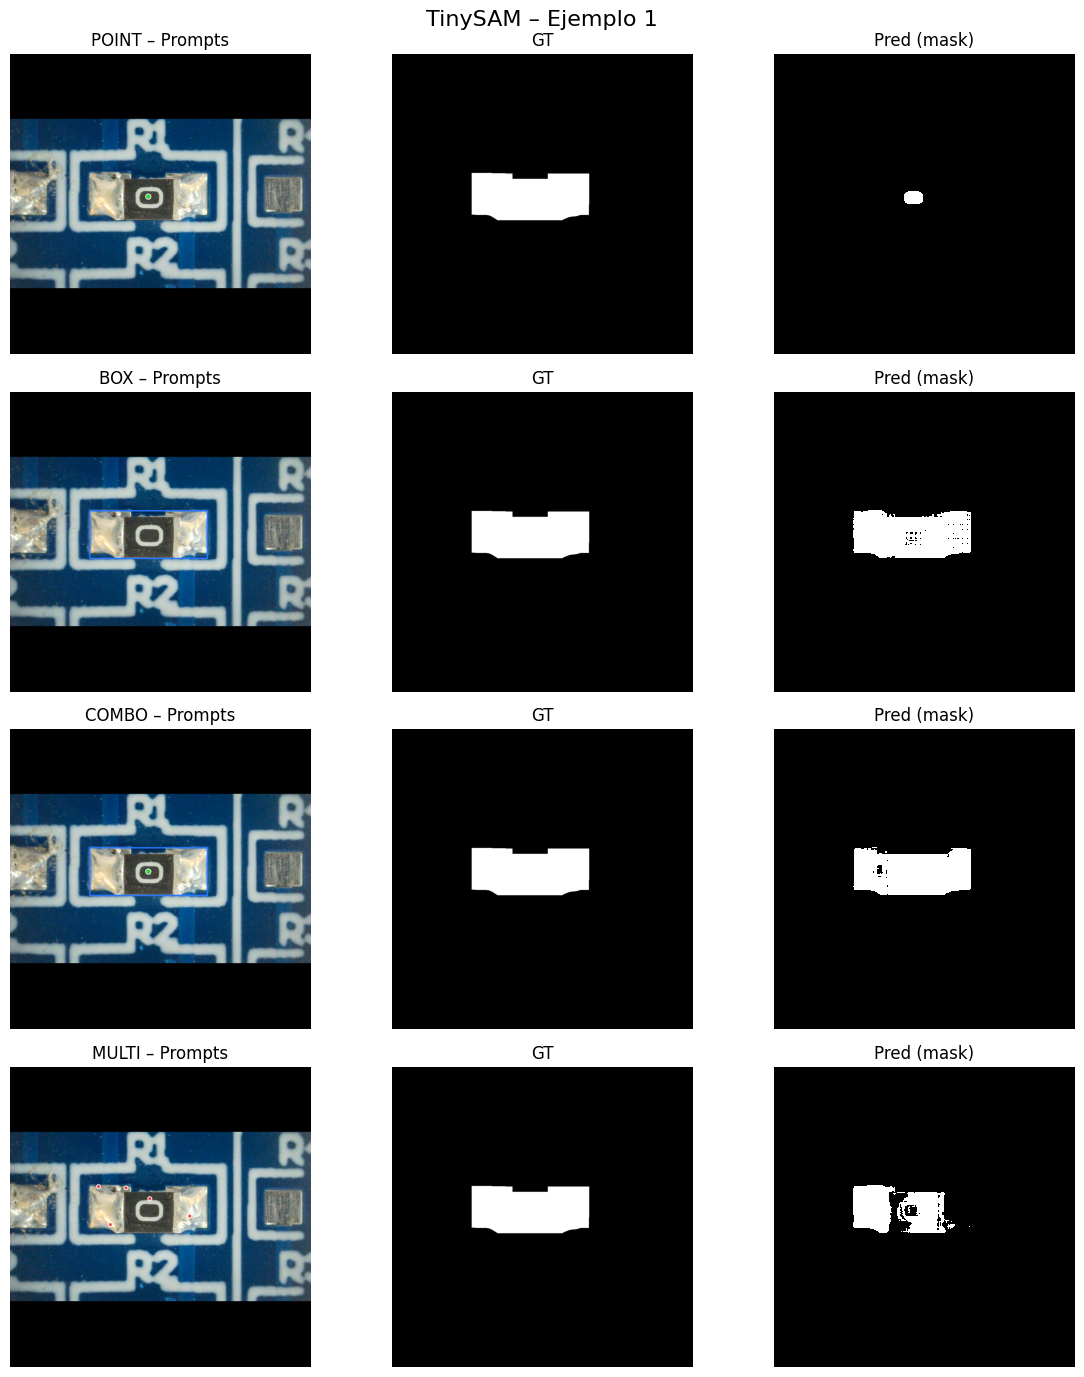

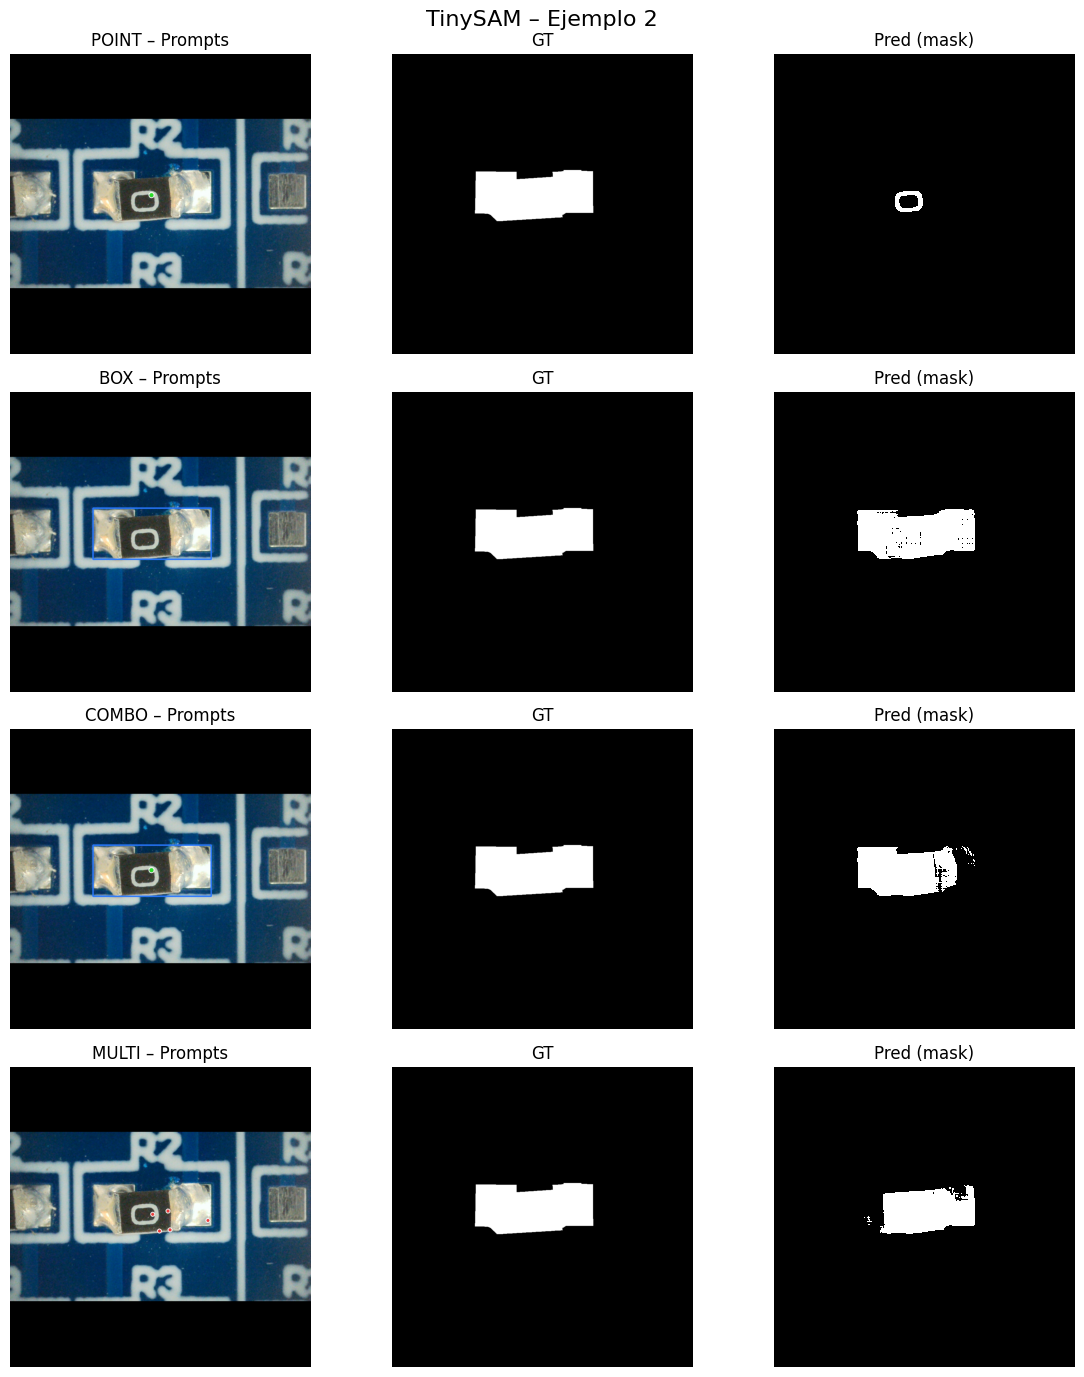

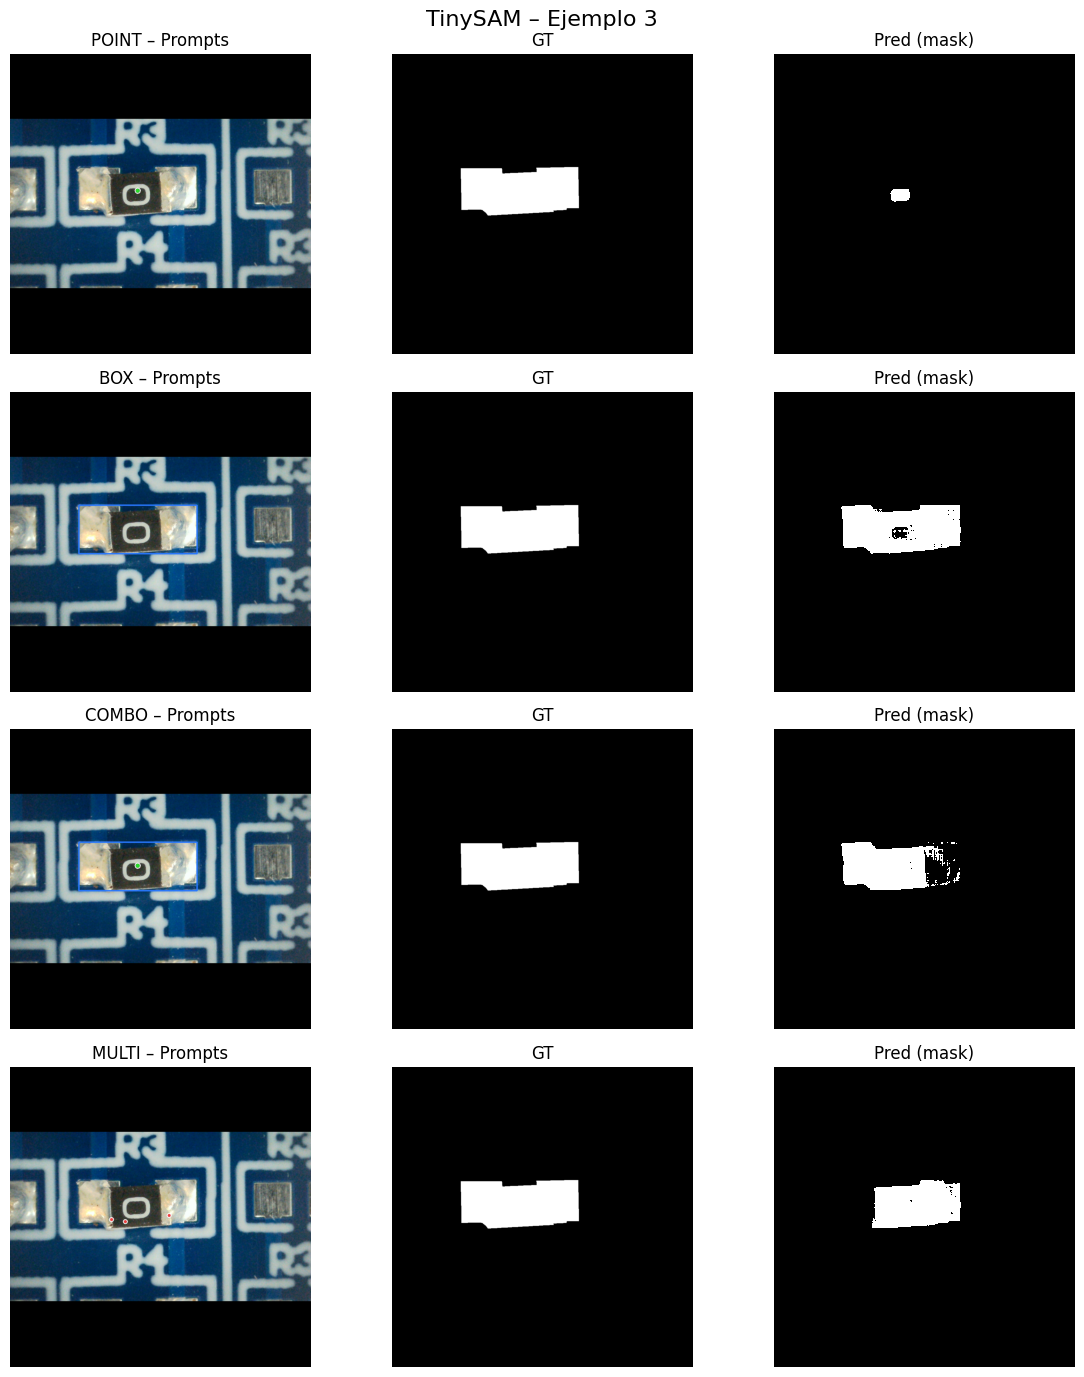

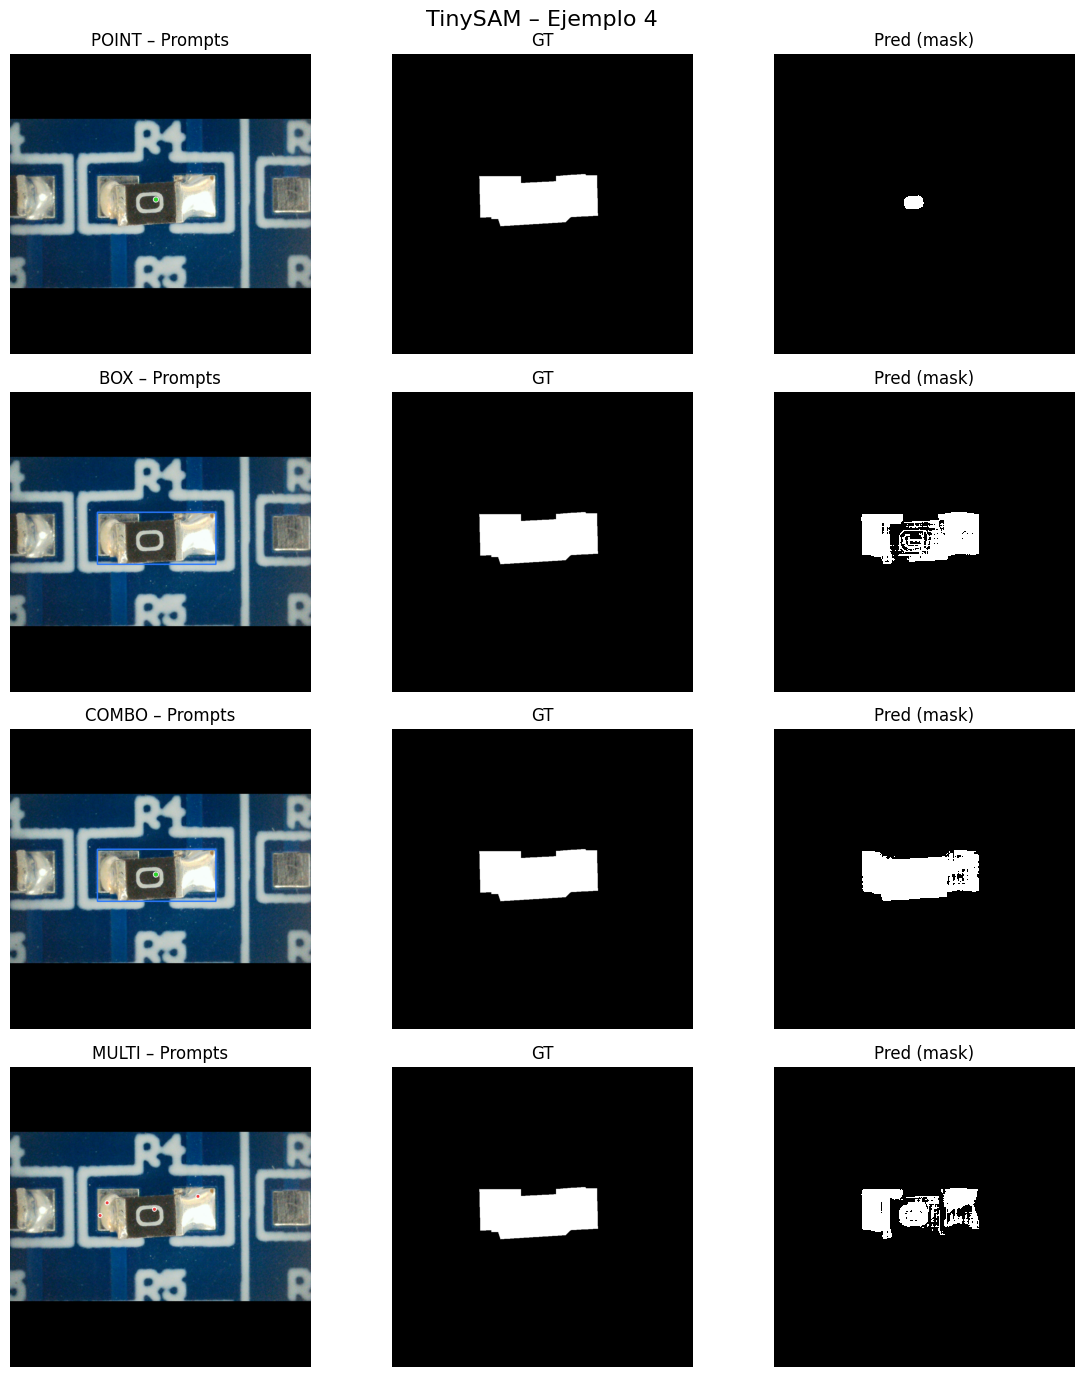

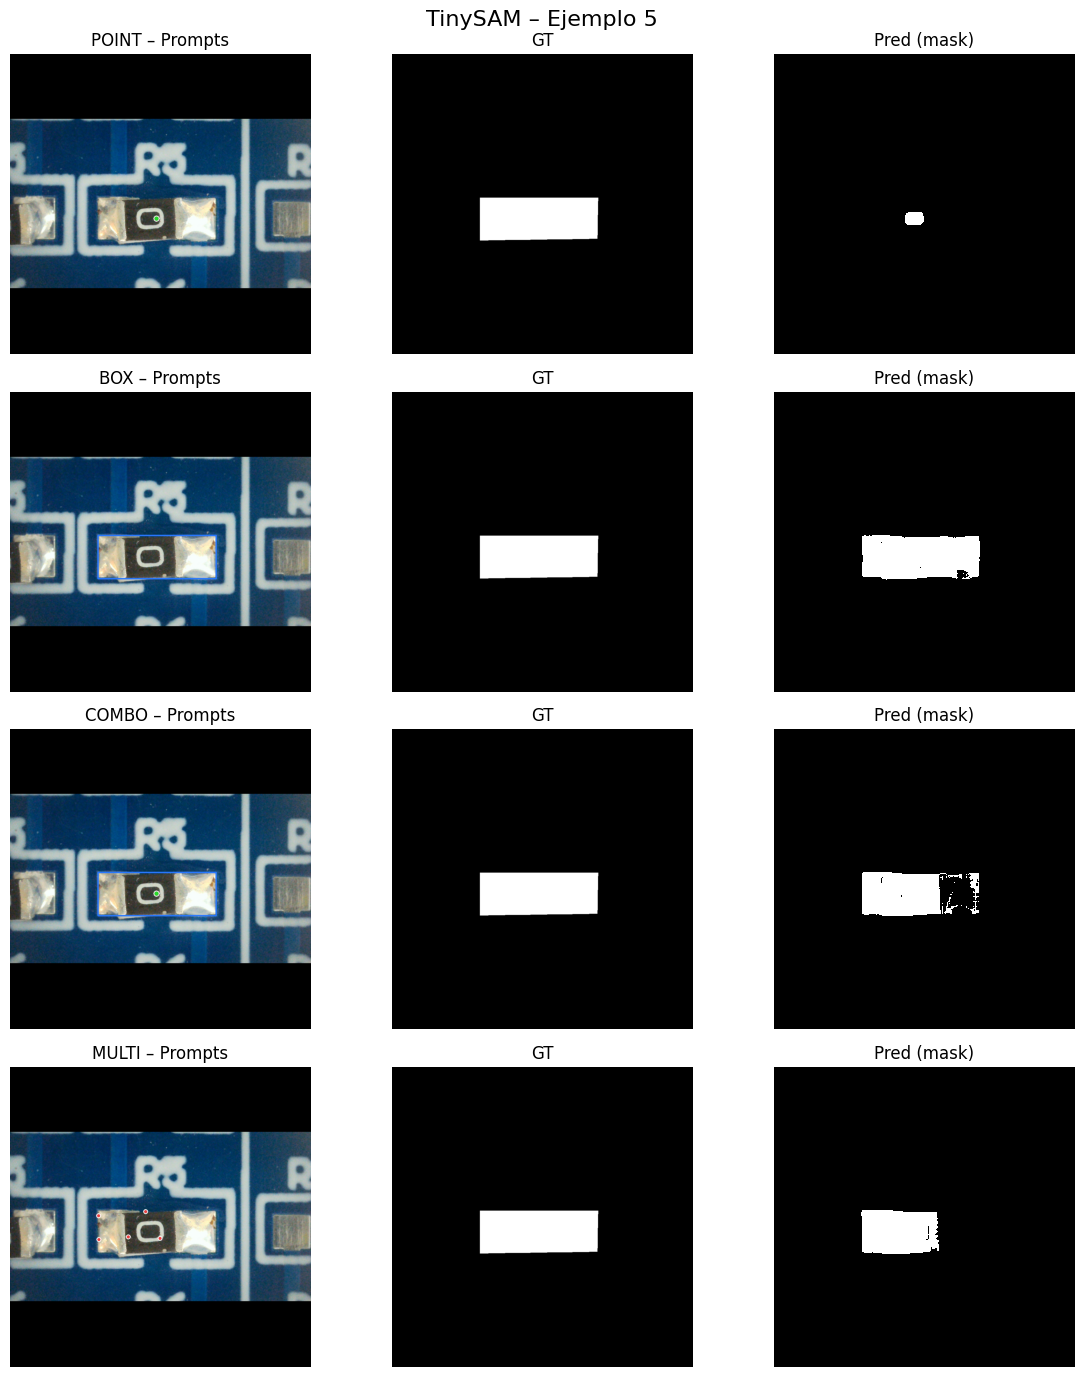

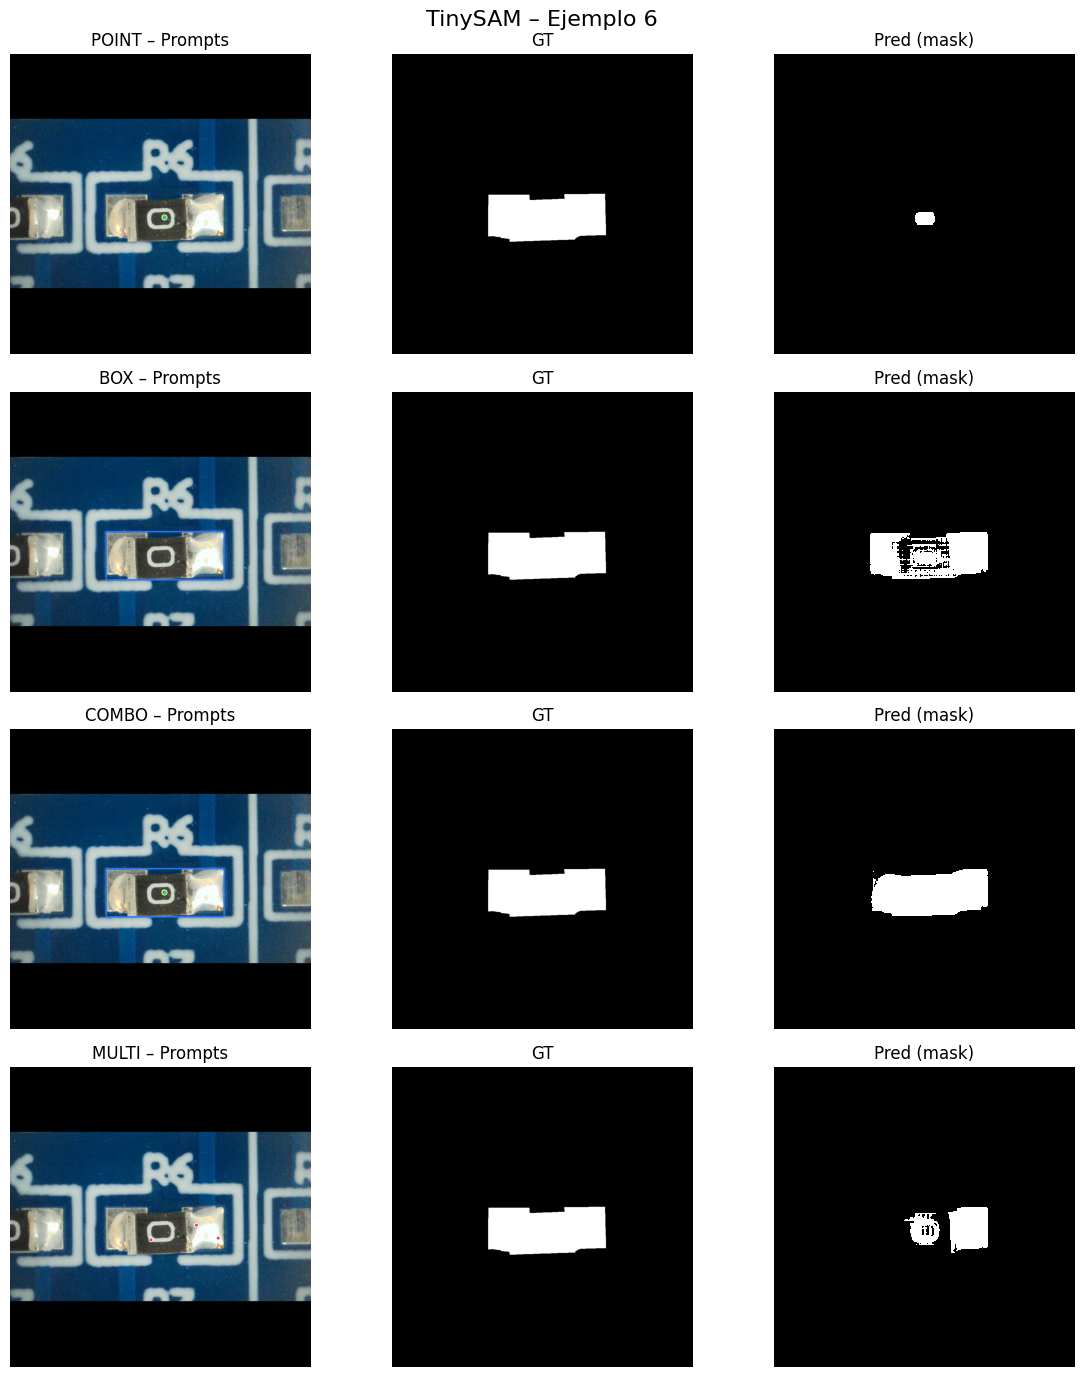

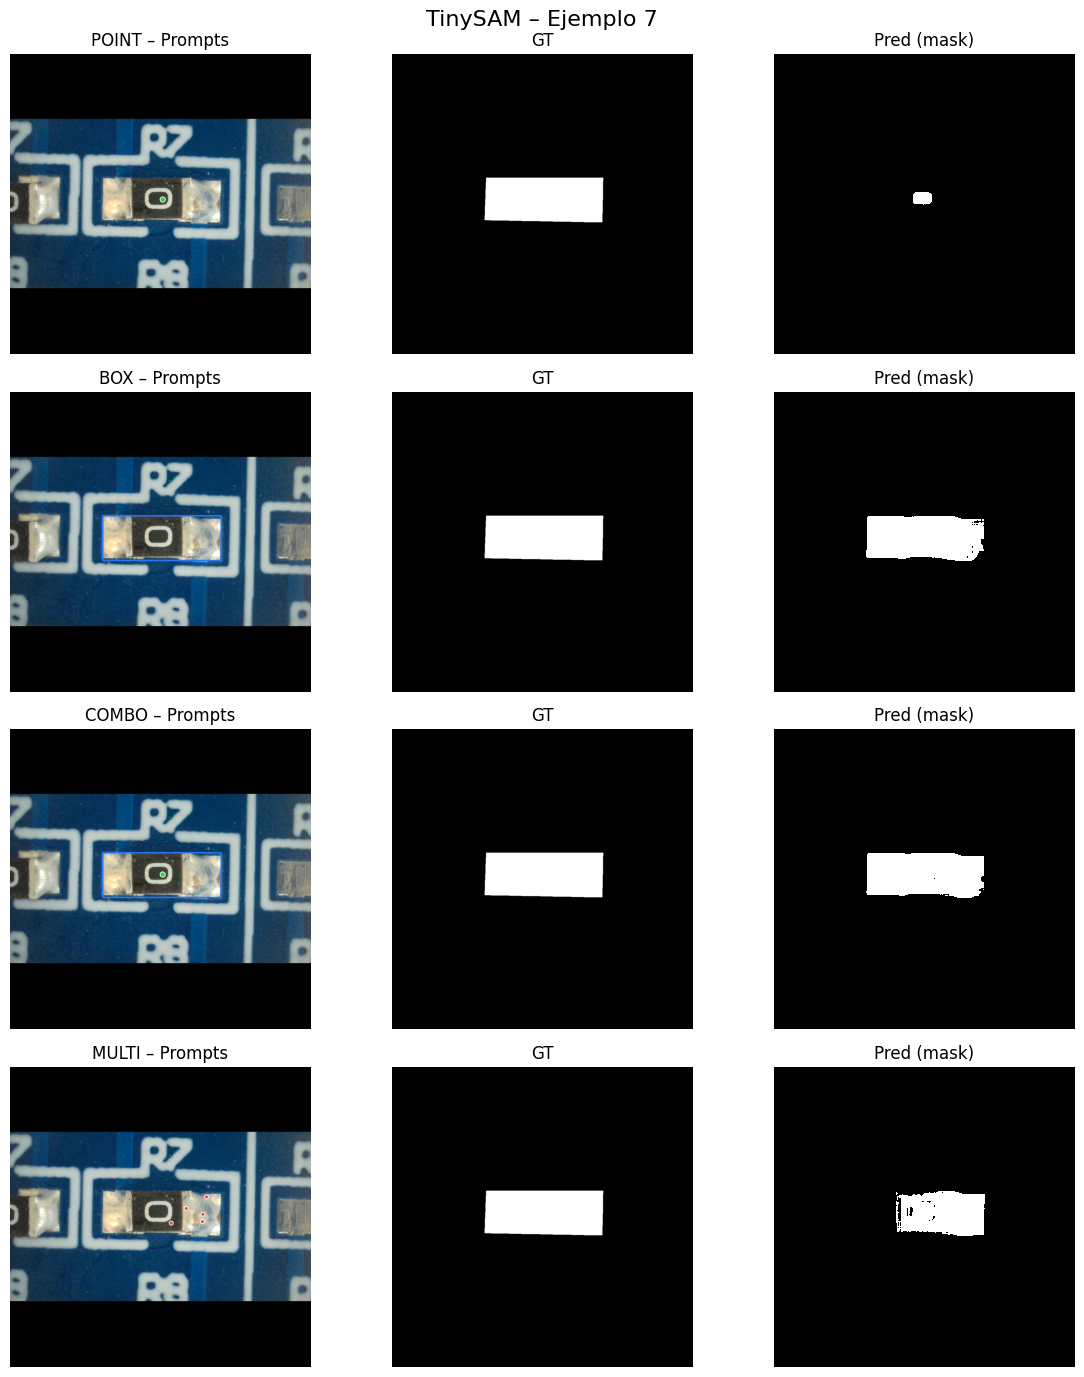

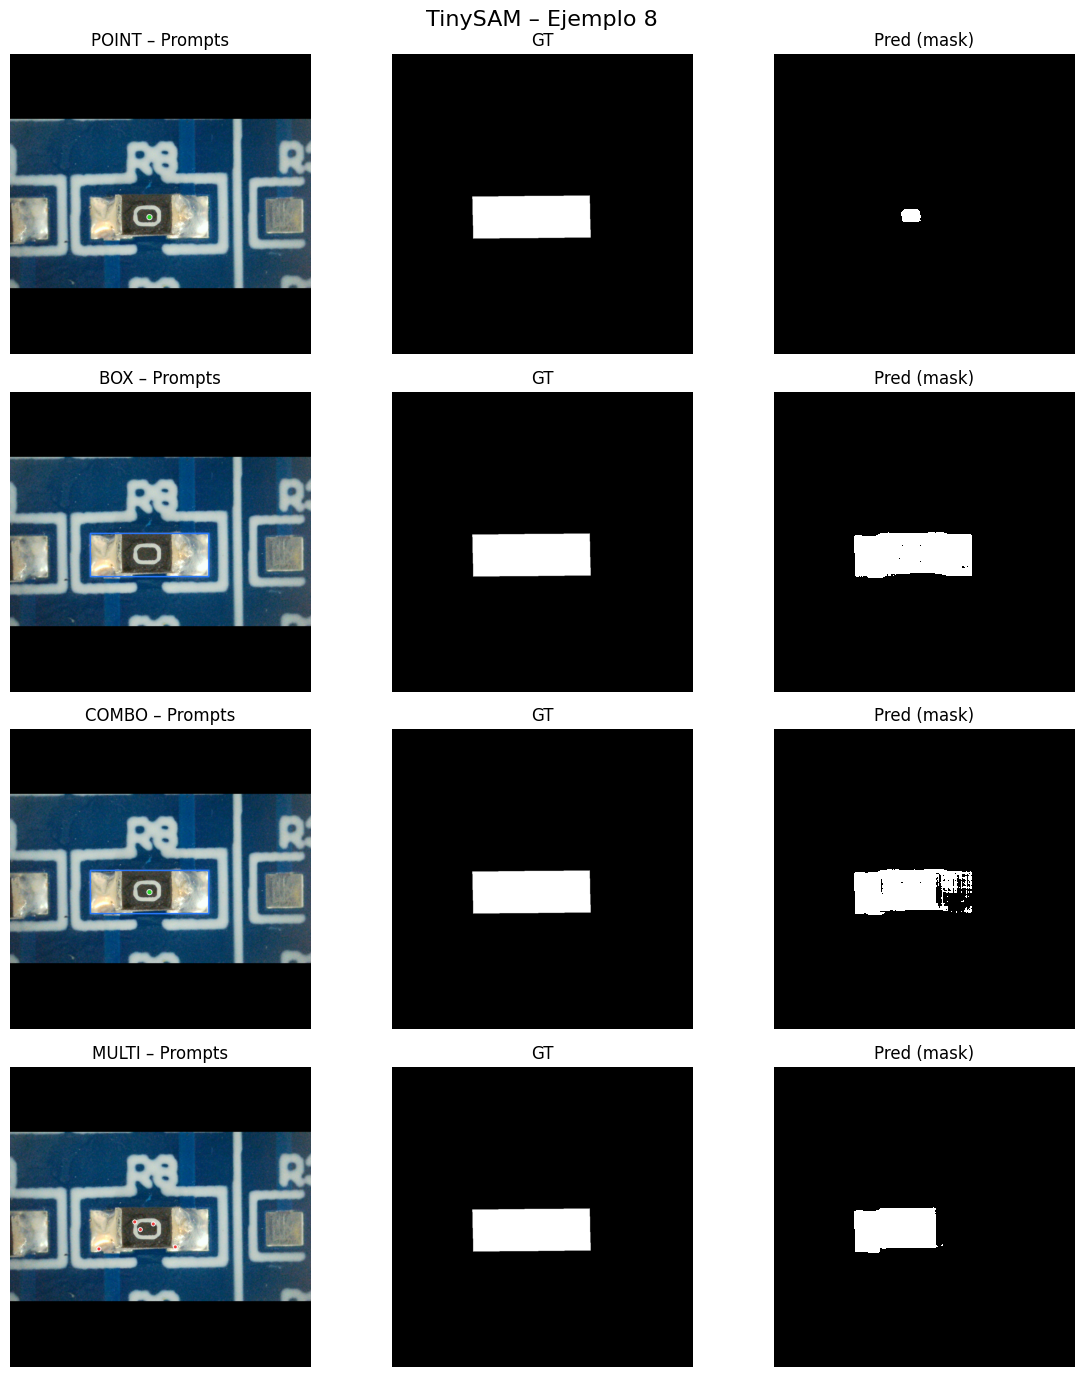

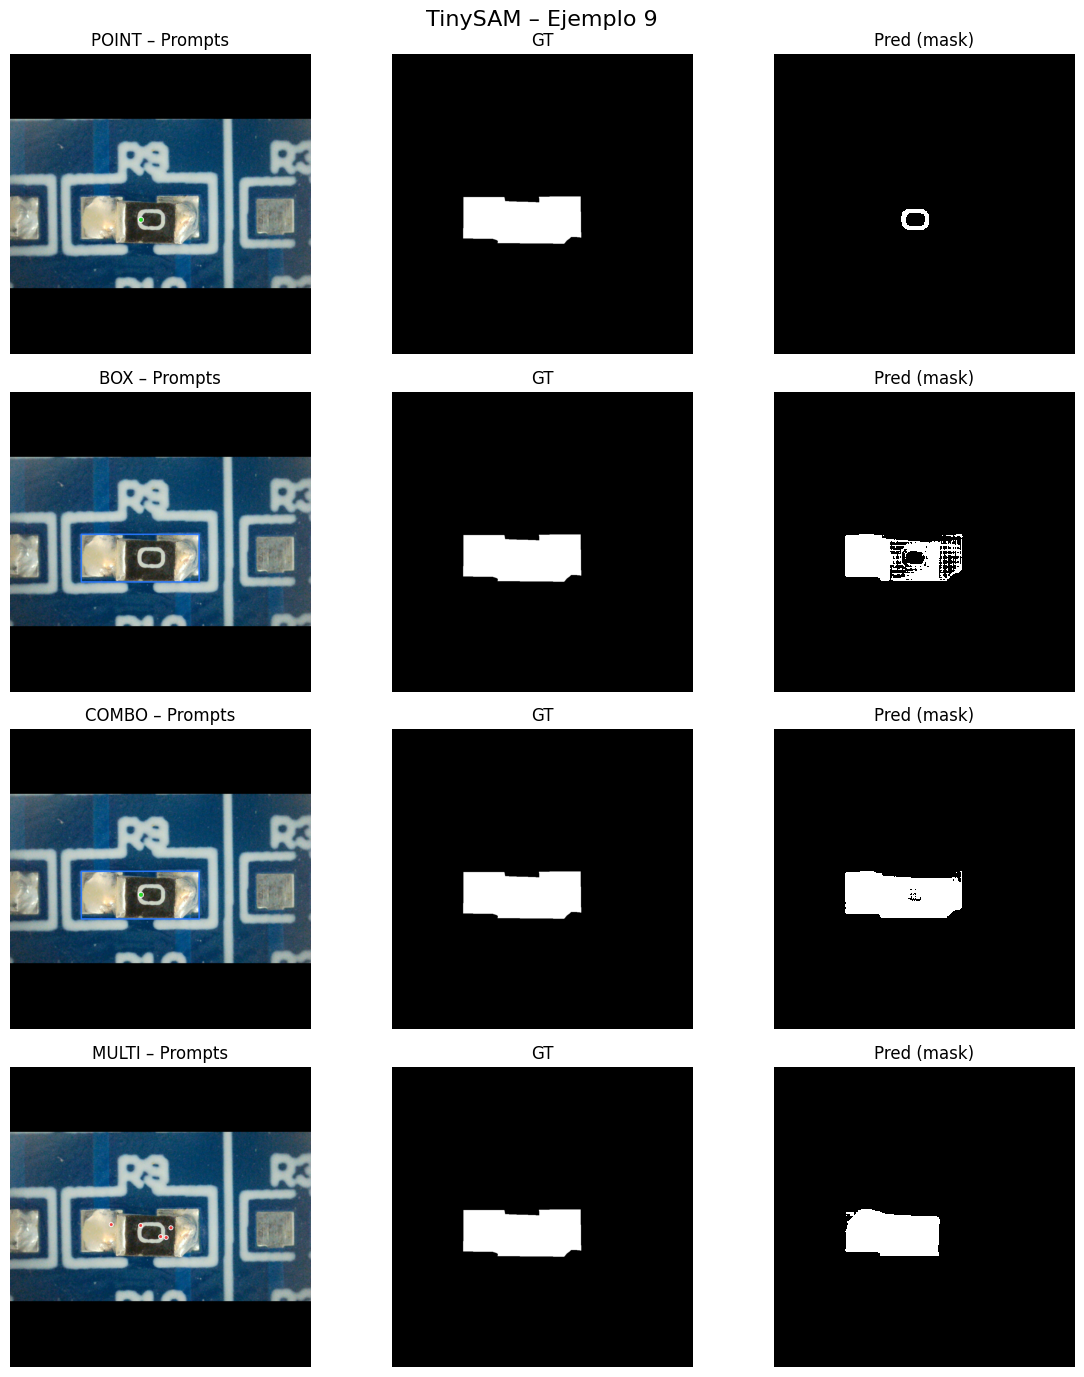

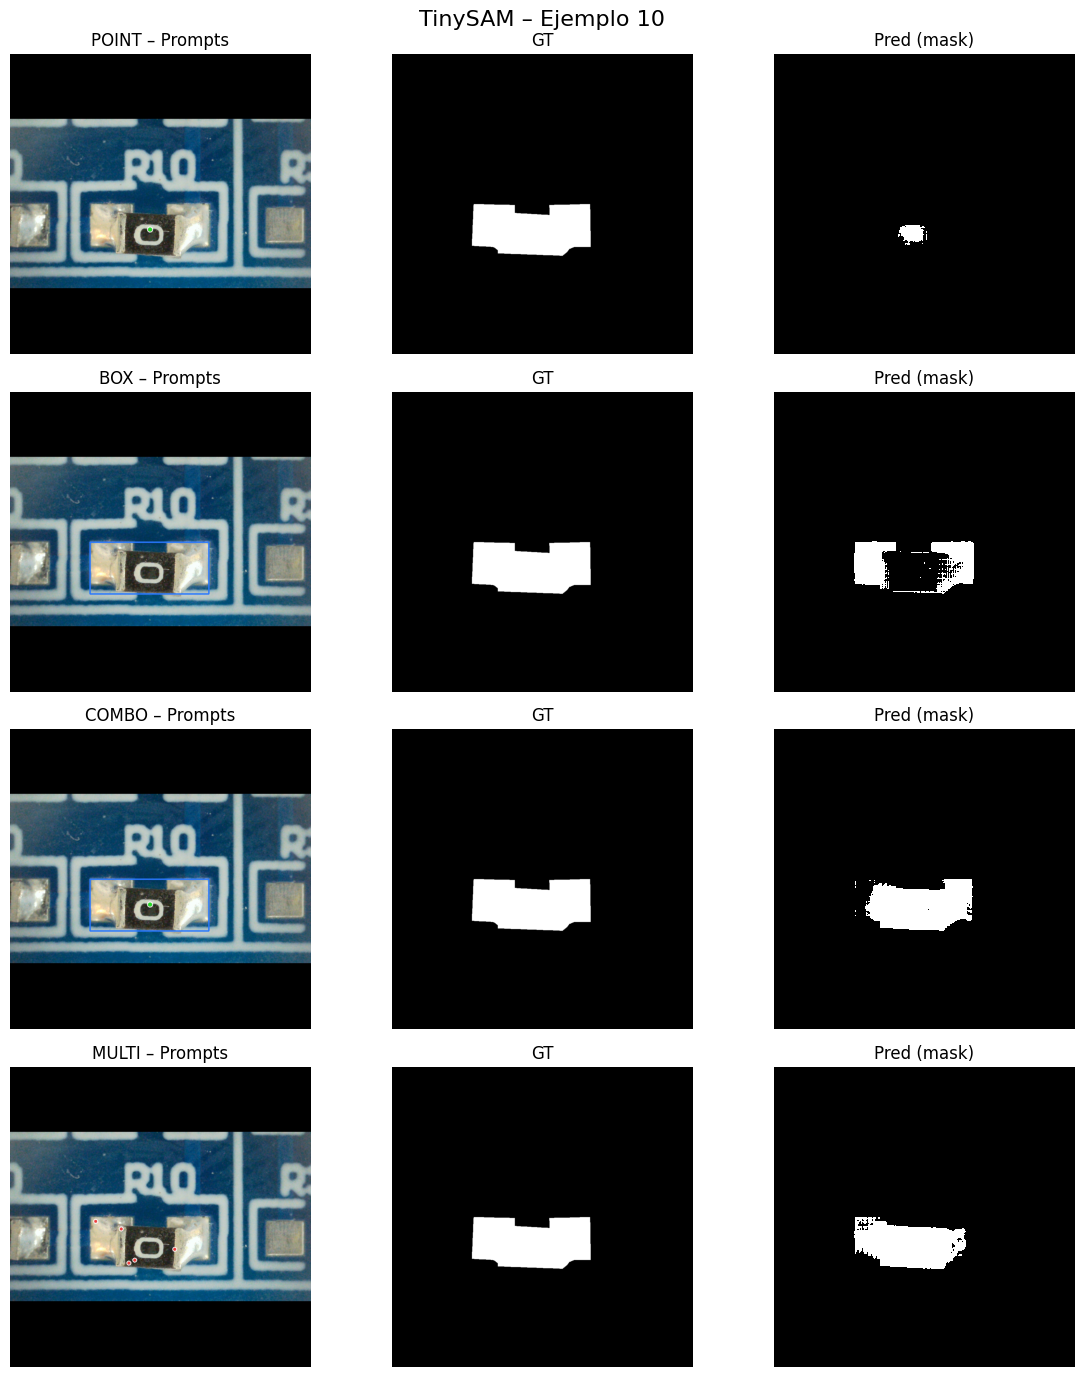

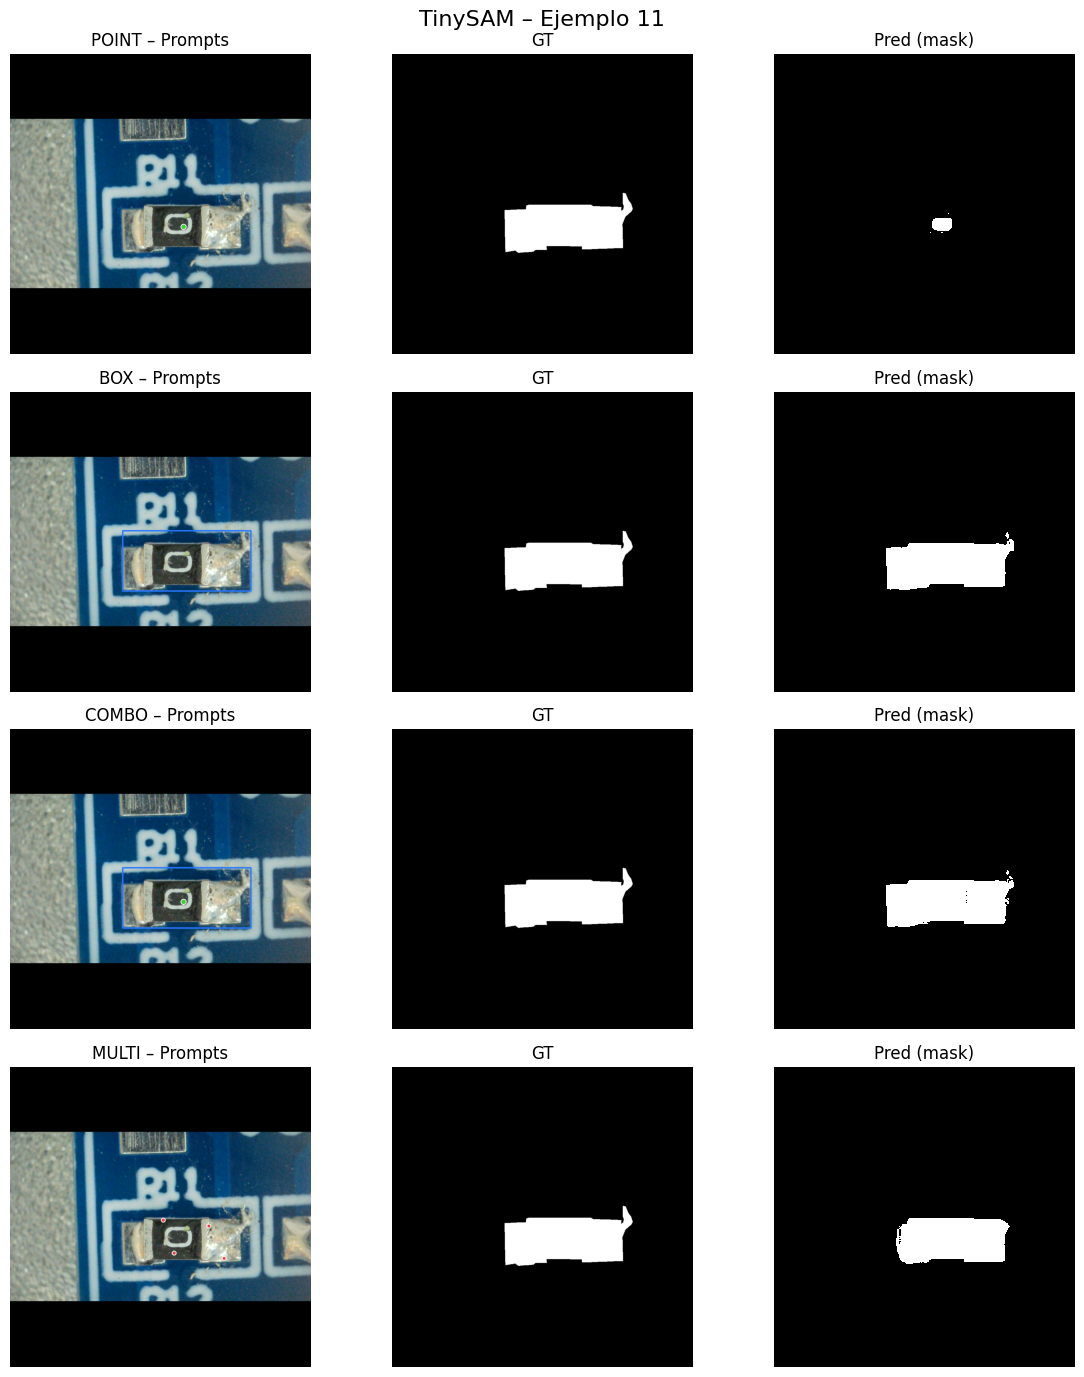

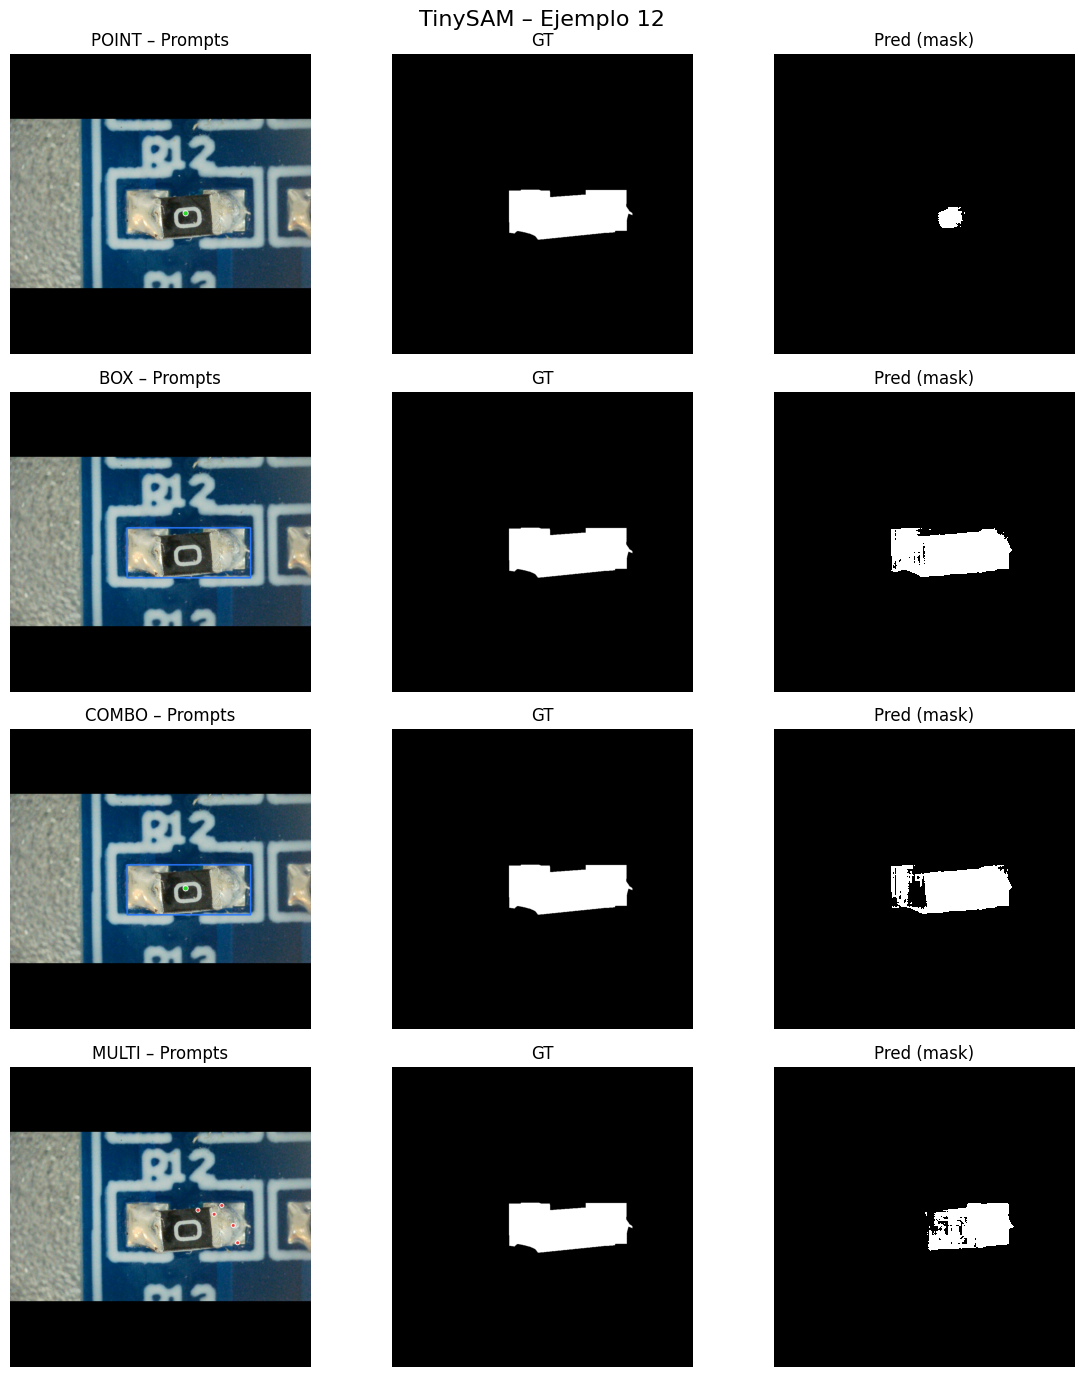

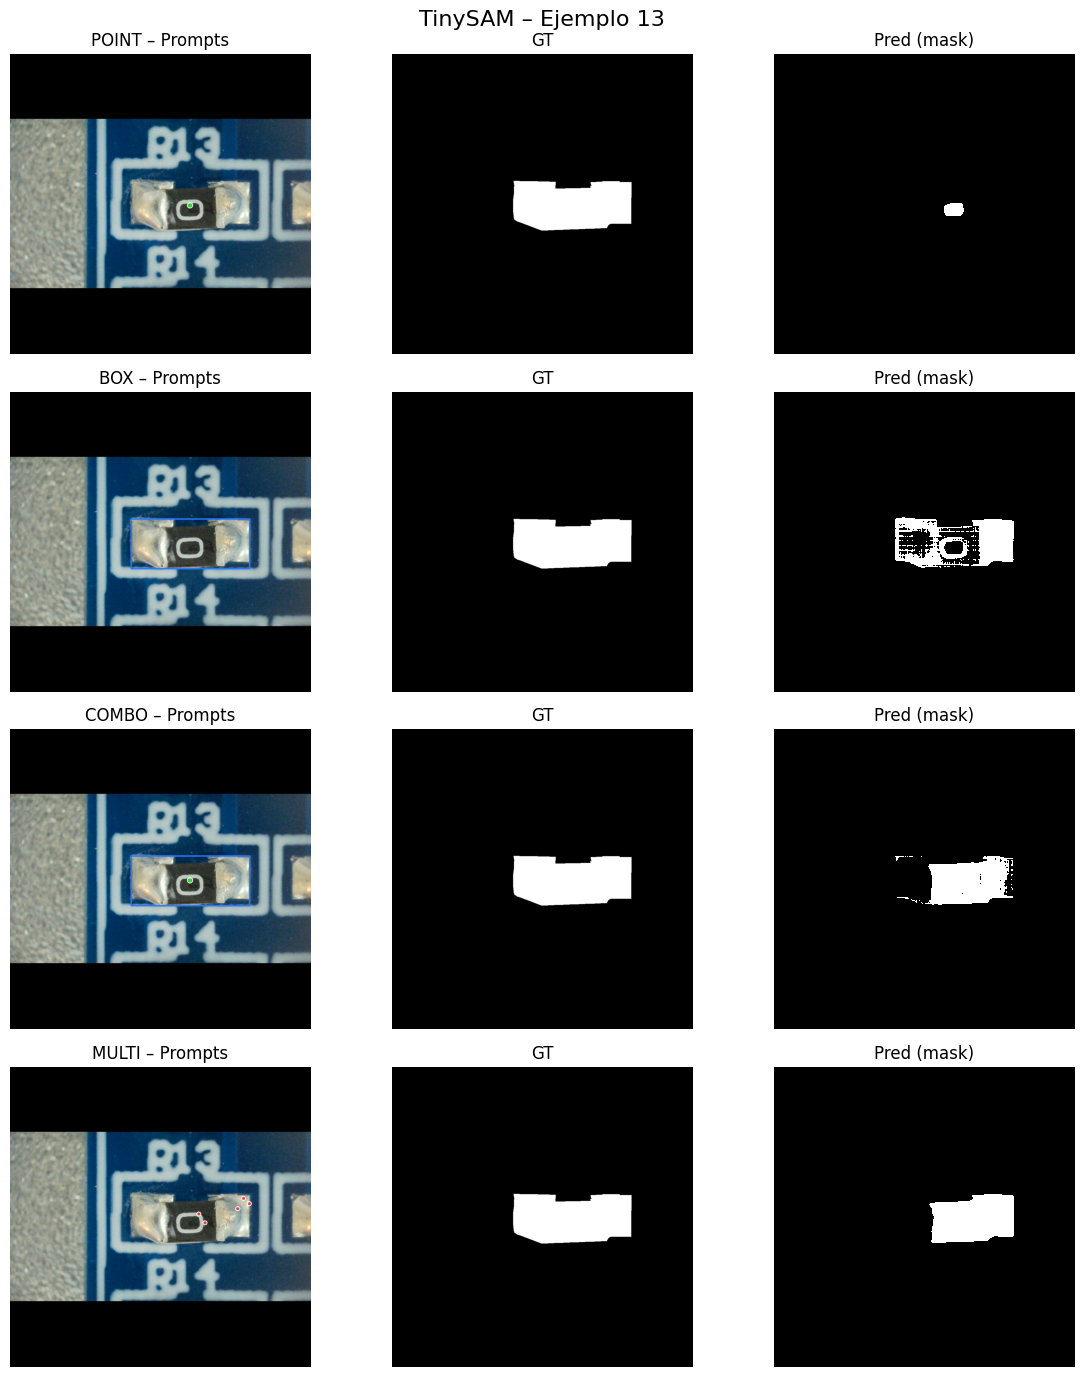

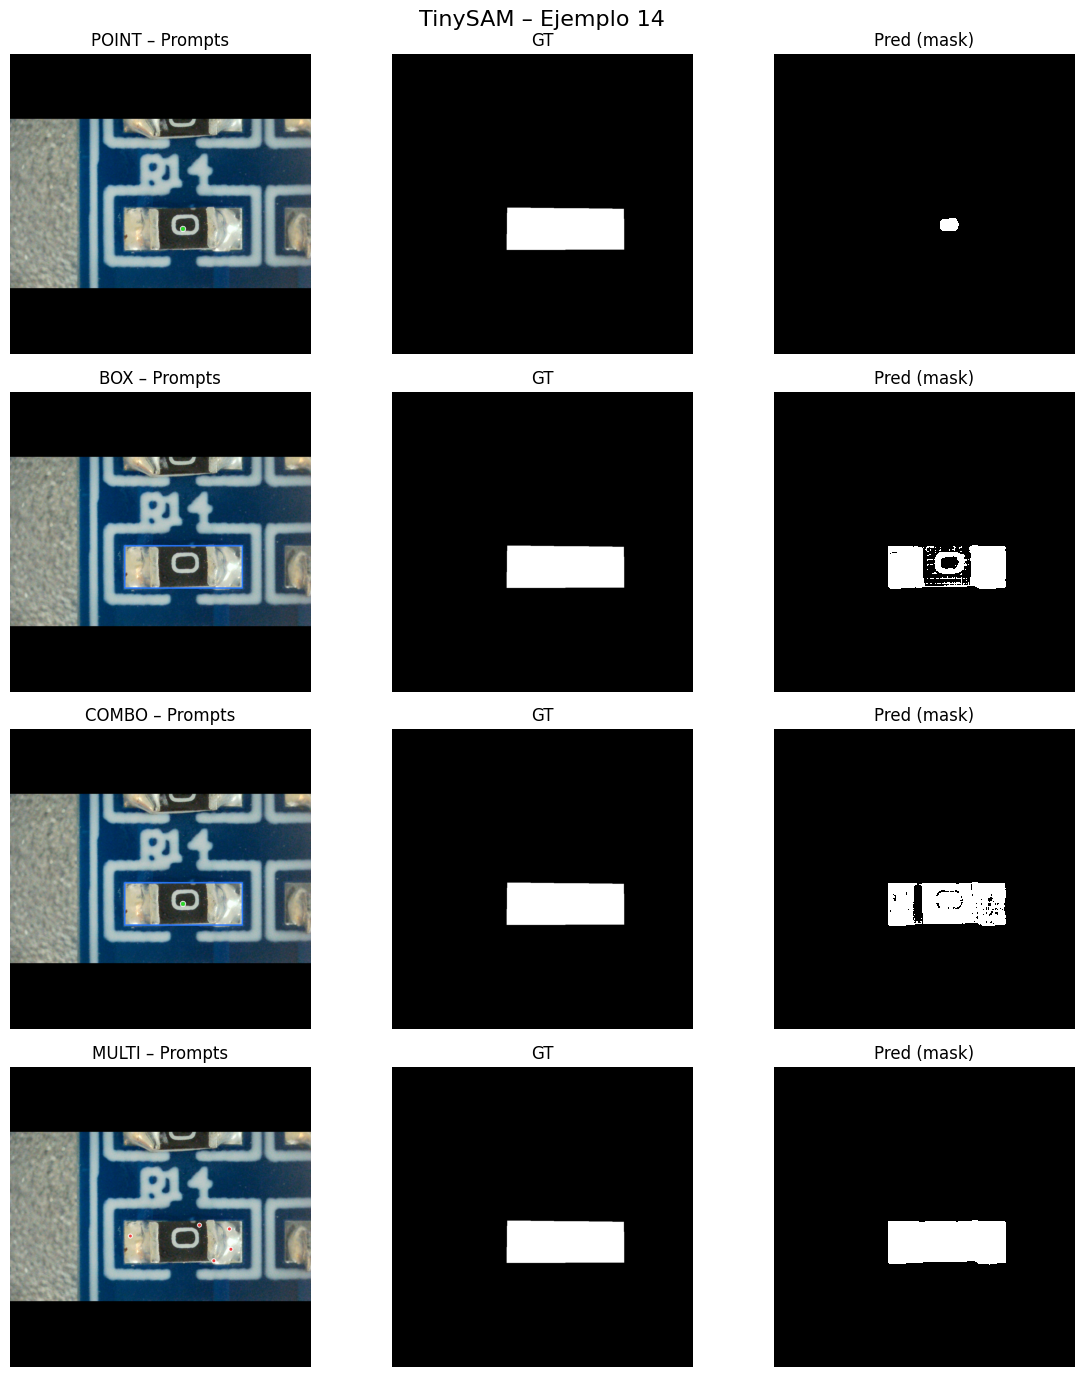

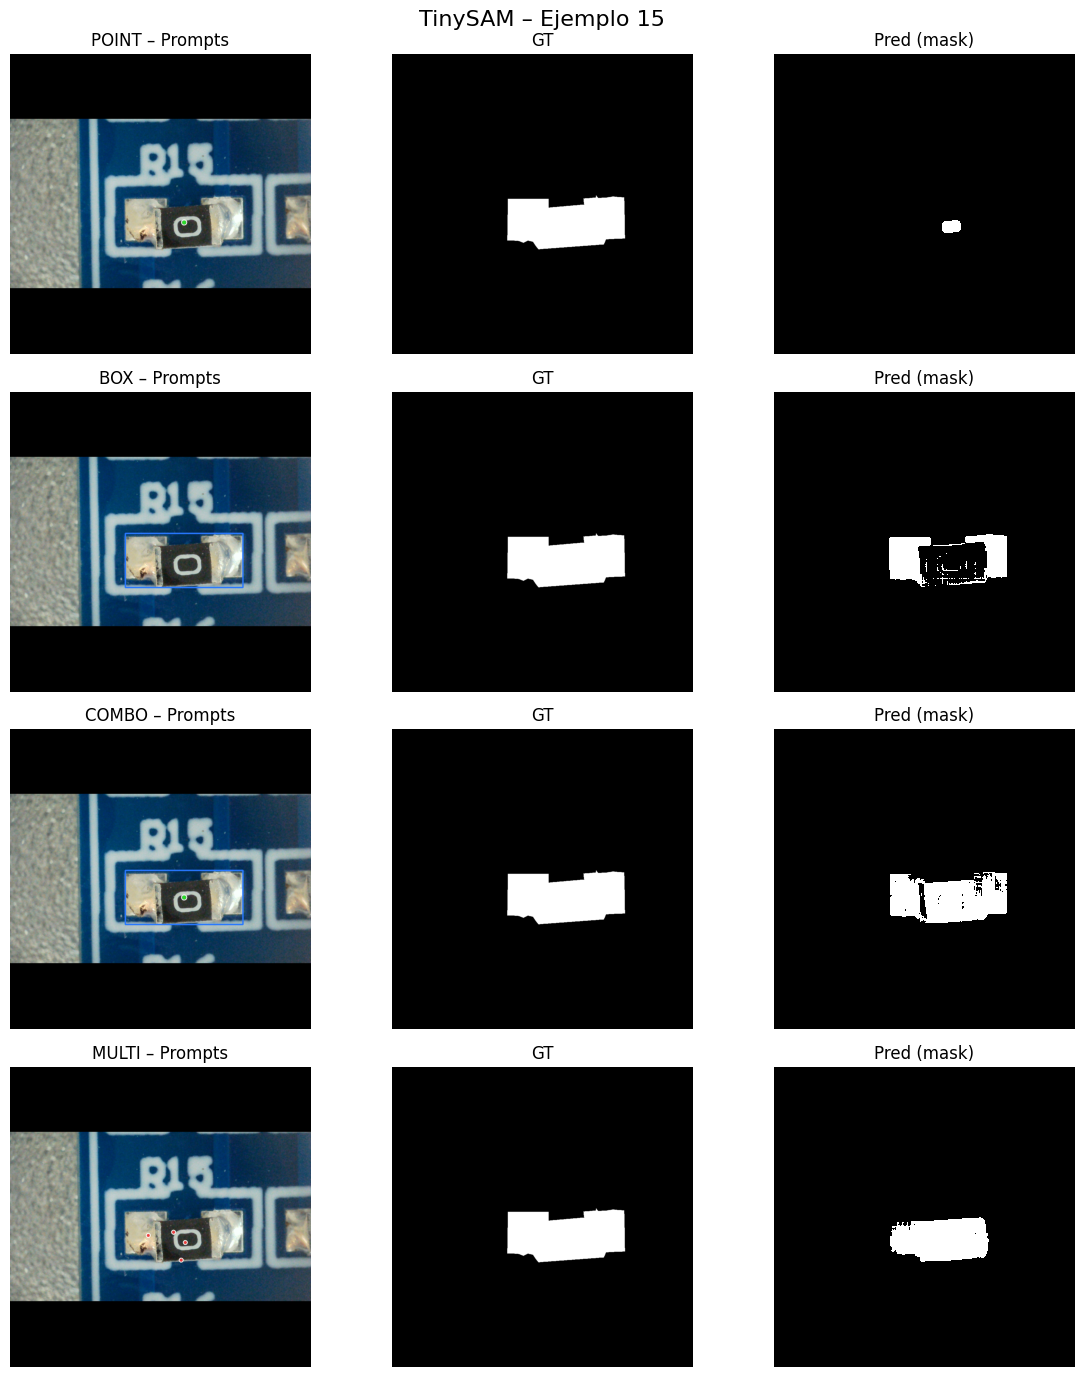

In [ ]:
visualize_tinysam_examples(
    model_tinysam, image_paths, mask_paths,
    n_examples=15, n_multi_points=5, thr=0.5,
    save_dir=None, clean=False, pred_viz="mask"   # máscara blanca sobre negro
)

